In [1]:
import pickle
import gzip
import random
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import train
import build_features

from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

% matplotlib inline

In [2]:
# prec_total = pickle.load(open('outputs_20180205-145823/prec_total.pkl', 'rb'))
# recall_total = pickle.load(open('outputs_20180205-145823/recall_total.pkl', 'rb'))
# spec_total = pickle.load(open('outputs_20180205-145823/spec_total.pkl', 'rb'))
# titles_total = pickle.load(open('outputs_20180205-145823/titles_total.pkl', 'rb'))
# model_list = pickle.load(open('outputs_20180205-145823/model_list.pkl', 'rb'))

# auc_list = pickle.load(open('outputs_20180205-145823/auc_list.pkl', 'rb'))
# r2_list = pickle.load(open('outputs_20180205-145823/r2_list.pkl', 'rb'))

# feature_headers = pickle.load(open('outputs_20180205-145823/feature_headers.pkl', 'rb'))
# mrns = pickle.load(open('outputs_20180205-145823/mrns.pkl', 'rb'))
# y = pickle.load(open('outputs_20180205-145823/y.pkl', 'rb'))
# y_label = pickle.load(open('outputs_20180205-145823/y_label.pkl', 'rb'))
# x_w_maternal = np.load('outputs_20180205-145823/x_w_maternal.npy')
# x_no_maternal = np.load('outputs_20180205-145823/x_no_maternal.npy')

In [3]:
d1 = pickle.load(open('../python objects/patientdata_20170823.pkl', 'rb'))
d1mom = pickle.load(open('../python objects/patient_mother_data_20170724.pkl', 'rb'))
lat_lon_dic = pickle.load(open('../python objects/lat_lon_data_20170920.pkl', 'rb'))
env_dic= pickle.load(open('../python objects/census_data_20170920.pkl', 'rb'))
d1mom_hist = pickle.load(open('../python objects/full_lutheran_mother_data.pkl', 'rb'))

# x_no_maternal,y,ylabel,feature_headers,mrns = build_features.call_build_function(d1, d1mom, d1mom_hist, lat_lon_dic, env_dic, 4.5, 5.5,  0, 24, False)
# x_w_maternal,y,ylabel,feature_headers,mrns = build_features.call_build_function(d1, d1mom, d1mom_hist, lat_lon_dic, env_dic, 4.5, 5.5,  0, 24, False)

# del d1, d1mom, lat_lon_dic, env_dic, d1mom_hist

In [4]:
filterSTR = ['Vital: Wt-avg0to1','Vital: Wt-avg1to3','Vital: Wt-avg10to13','Vital: Wt-avg19to24','Vital: BMI-avg0to1','Vital: BMI-avg1to3','Vital: BMI-avg10to13','Vital: BMI-avg19to24']
filterSTRThresh = [0.5]
mrnForFilter = []
percentile = False
agex_low = 4.5
agex_high = 5.5
months_from = 0
months_to = 24

### PREPARE DATA GENERALLY ###

print('Creating data from the provided data dictionaries')
x1, y1, y1label, feature_headers, mrns = build_features.call_build_function(d1, d1mom, d1mom_hist, lat_lon_dic, env_dic, agex_low, agex_high, months_from, months_to, percentile, mrnsForFilter=mrnForFilter)

bin_ix = np.array([(h.startswith('Diagnosis:') or h.startswith('Maternal Diagnosis:') or h.startswith('Newborn Diagnosis:')) for h in feature_headers])
print(bin_ix.sum(), 'features are binary')
x1[:,bin_ix] = (x1[:,bin_ix] > 0) * 1.0

### SEPARATE BOYS AND GIRLS DATA AND PROCESS ###

ix_girls, x2_girls, y2_girls, y2label_girls, mrns_girls = train.filter_training_set_forLinear(x1, y1, y1label, feature_headers, filterSTR+['Gender:1 female'], percentile, mrns, filterSTRThresh)
x2_girls, mux, stdx, bin_ix, unobserved = train.normalize(x2_girls, bin_ix=bin_ix)
ix_boys, x2_boys, y2_boys, y2label_boys, mrns_boys = train.filter_training_set_forLinear(x1, y1, y1label, feature_headers, filterSTR+['Gender:0 male'], percentile, mrns, filterSTRThresh)
x2_boys, mux, stdx, bin_ix, unobserved = train.normalize(x2_boys, bin_ix=bin_ix)

corr_headers_girls = np.array(feature_headers)
corr_matrix_girls = np.corrcoef(x2_girls.transpose())
corr_headers_filtered_girls, corr_matrix_filtered_girls, ix_corr_headers_girls = train.filter_correlations_via(corr_headers_girls, corr_matrix_girls, ['Vital'])
print('girls corr matrix is filtered to size', corr_matrix_filtered_girls.shape)
corr_headers_boys = np.array(feature_headers)
corr_matrix_boys = np.corrcoef(x2_boys.transpose())
corr_headers_filtered_boys, corr_matrix_filtered_boys, ix_corr_headers_boys = train.filter_correlations_via(corr_headers_boys, corr_matrix_boys, ['Vital'])
print('boys corr matrix is filtered to size', corr_matrix_filtered_boys.shape)

# x2, feature_headers = train.variable_subset(x2, variablesubset, feature_headers)

print ('girls output is: average:{0:4.3f}'.format(y2_girls.mean()), ' min:', y2_girls.min(), ' max:', y2_girls.max())
print ('normalizing girls output.'); y2_girls = (y2_girls-y2_girls.mean())/y2_girls.std()
print ('boys output is: average:{0:4.3f}'.format(y2_boys.mean()), ' min:', y2_boys.min(), ' max:', y2_boys.max())
print ('normalizing boys output.'); y2_boys = (y2_boys-y2_boys.mean())/y2_boys.std()

print ('Predicting BMI at age:'+str(agex_low)+ ' to '+str(agex_high)+ 'years, from data in ages:'+ str(months_from)+'-'+str(months_to) + ' months')
if filterSTR != '':
    print ('filtering patients with: ' , filterSTR)

print ('girls total size',ix_girls.sum())
print ('boys total size',ix_boys.sum())

Creating data from the provided data dictionaries
5094 features are binary
x shape: (52945, 18895) num features: 18895
1050 patients selected..


/Volumes/CPO/ObesityPY/src/train.py:168: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(xcop, axis=0)
/Users/hammor01/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1427: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


x shape: (52945, 18895) num features: 18895
1060 patients selected..


/Users/hammor01/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/hammor01/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


18471
girls corr matrix is filtered to size (18895, 18471)
18471
boys corr matrix is filtered to size (18895, 18471)
girls output is: average:16.477  min: 11.2275  max: 35.0625
normalizing girls output.
boys output is: average:16.927  min: 11.915  max: 38.514
normalizing boys output.
Predicting BMI at age:4.5 to 5.5years, from data in ages:0-24 months
filtering patients with:  ['Vital: Wt-avg0to1', 'Vital: Wt-avg1to3', 'Vital: Wt-avg10to13', 'Vital: Wt-avg19to24', 'Vital: BMI-avg0to1', 'Vital: BMI-avg1to3', 'Vital: BMI-avg10to13', 'Vital: BMI-avg19to24']
girls total size 1050
boys total size 1060


In [5]:
### TRAIN-TEST SPLIT -- GIRLS ###

randix_girls = list(range(0, x2_girls.shape[0]))
random.shuffle(randix_girls)
train_ix_girls = randix_girls[0:int(len(randix_girls)*2/3)]
test_ix_girls = randix_girls[int(len(randix_girls)*2/3):]

xtrain_girls = x2_girls[train_ix_girls,:]
mrnstrain_girls = mrns_girls[train_ix_girls]
ytrain_girls = y2_girls[train_ix_girls]
ytrainlabel_girls = y2label_girls[train_ix_girls]

xtest_girls = x2_girls[test_ix_girls,:]
mrnstest_girls = mrns_girls[test_ix_girls]
ytest_girls =  y2_girls[test_ix_girls]
ytestlabel_girls = y2label_girls[test_ix_girls]

### TRAIN-TEST SPLIT -- BOYS ###

randix_boys = list(range(0, x2_boys.shape[0]))
random.shuffle(randix_boys)
train_ix_boys = randix_boys[0:int(len(randix_boys)*2/3)]
test_ix_boys = randix_boys[int(len(randix_boys)*2/3):]

xtrain_boys = x2_boys[train_ix_boys,:]
mrnstrain_boys = mrns_boys[train_ix_boys]
ytrain_boys = y2_boys[train_ix_boys]
ytrainlabel_boys = y2label_boys[train_ix_boys]

xtest_boys = x2_boys[test_ix_boys,:]
mrnstest_boys = mrns_boys[test_ix_boys]
ytest_boys =  y2_boys[test_ix_boys]
ytestlabel_boys = y2label_boys[test_ix_boys]

In [6]:
### MODELING OUTPUT LISTS###

prec_total = []
recall_total = []
spec_total = []
titles_total = []
model_list = []
auc_list = []
r2_list = []

In [7]:
### TRAIN THE RANDOM FORESTS ###

print('Randomforest - girls w/ vitals and maternal - 24 months to 5 years')
clf_rf_girls = RandomForestRegressor(random_state=0, n_estimators=3000, min_samples_split=2, min_samples_leaf=7, n_jobs=-1)
clf_rf_girls.fit(xtrain_girls,ytrain_girls)

ytrain_pred_girls = clf_rf_girls.predict(xtrain_girls)
fpr, tpr, thresholds = metrics.roc_curve(ytrainlabel_girls, ytrain_pred_girls)
print('AUC train: {0:4.3f}'.format(metrics.auc(fpr, tpr)) + ' Explained Variance Score Train: {0:4.3f}'.format(metrics.explained_variance_score(ytrain_girls, ytrain_pred_girls))) #http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

ytest_pred_girls = clf_rf_girls.predict(xtest_girls)
fpr, tpr, thresholds = metrics.roc_curve(ytestlabel_girls, ytest_pred_girls)
auc_test = metrics.auc(fpr, tpr)
r2test = clf_rf_girls.score(xtest_girls, ytest_girls)
print('AUC test: {0:4.3f}'.format(metrics.auc(fpr, tpr))+' Explained Variance Score Test: {0:4.3f}'.format(metrics.explained_variance_score(ytest_girls, ytest_pred_girls)))

model_weights_girls = clf_rf_girls.feature_importances_
sorted_ix_girls = np.argsort(-1* abs(model_weights_girls))
weights_girls = model_weights_girls[sorted_ix_girls]

factors_girls = np.array(feature_headers)[sorted_ix_girls]
x2_reordered_girls = x2_girls[:,sorted_ix_girls]
xtest_reordered_girls = xtest_girls[:, sorted_ix_girls]

operating_Thresholds_girls = []
operating_levels = [0, 0.0001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ix_level = 0
for ix, thr in enumerate(thresholds):
    if fpr[ix] >= operating_levels[ix_level]:
        operating_Thresholds_girls.append(thr)
        ix_level += 1
        if ix_level == len(operating_levels):
            break

operating_Thresholds_girls = thresholds
report_metrics_girls = 'Test set metrics:\n'
prec_list = []
recall_list = []
spec_list = []
for t in operating_Thresholds_girls:
    tp = ((ytestlabel_girls > 0) & (ytest_pred_girls.ravel() > t)).sum()*1.0
    tn = ((ytestlabel_girls == 0) & (ytest_pred_girls.ravel() <= t)).sum()*1.0
    fn = ((ytestlabel_girls > 0) & (ytest_pred_girls.ravel() <= t)).sum()*1.0
    fp = ((ytestlabel_girls == 0) & (ytest_pred_girls.ravel() > t)).sum()*1.0

    sens = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0.0
    f1 = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) != 0 else 0.0

    report_metrics_girls += '@threshold:{0:4.3f}, sens:{1:4.3f}, spec:{2:4.3f}, ppv:{3:4.3f}, acc:{4:4.3f}, f1:{5:4.3f} total+:{6:4.3f}\n'.format(t, sens, spec, ppv, acc, f1, tp+fp)
    prec_list.append(ppv)
    recall_list.append(sens)
    spec_list.append(spec)

print(report_metrics_girls)
titles_total.append('Randomforest - girls w/ vitals and maternal - 24 months to 5 years')
model_list.append(clf_rf_girls)
prec_total.append(prec_list)
recall_total.append(recall_list)
spec_total.append(spec_list)
auc_list.append(auc_test)
r2_list.append(r2test)

occurences_girls = (x2_girls != 0).sum(axis=0)[sorted_ix_girls]
zip_weights_girls = {}
sig_headers_girls = []
feature_categories_girls = {}
for i in range(0, (abs(model_weights_girls)>0).sum()):
    fpr, tpr, thresholds = metrics.roc_curve(ytestlabel_girls, xtest_reordered_girls[:,i].ravel())
    feature_auc_indiv = metrics.auc(fpr, tpr)
    corrs = corr_matrix_filtered_girls[sorted_ix_girls[i],:].ravel()
    top_corr_ix = np.argsort(-1*abs(corrs))
    corr_string = 'Correlated most with:\n'+'    '.join( [str(corr_headers_filtered_girls[top_corr_ix[j]])+ ':' + "{0:4.3f}\n".format(corrs[top_corr_ix[j]]) for j in range(0,10)]  )

    tp = ((y2label_girls > 0) & (x2_reordered_girls[:,i].ravel() > 0)).sum()*1.0
    tn = ((y2label_girls == 0) & (x2_reordered_girls[:,i].ravel() <= 0)).sum()*1.0
    fn = ((y2label_girls > 0) & (x2_reordered_girls[:,i].ravel() <= 0)).sum()*1.0
    fp = ((y2label_girls == 0) & (x2_reordered_girls[:,i].ravel() > 0)).sum()*1.0

    if fp*fn*tp*tn == 0:
        oratio = np.nan
        low_OR = np.nan
        high_OR = np.nan
    else:
        oratio = tp*tn/(fp*fn)
        se = np.sqrt(1/tp + 1/fp + 1/tn + 1/fn)
        low_OR = np.exp(np.log(oratio) - 1.96 * se)
        high_OR = np.exp(np.log(oratio) + 1.96 * se)
    try:
        feature_categories_girls[factors_girls[i].split(':')[0]] += weights_girls[i]
    except:
        feature_categories_girls[factors_girls[i].split(':')[0]] = weights_girls[i]

    star = ' '
    if (low_OR > 1 or high_OR < 1): #or (weights[i]+terms_sorted[i]) < 0 or (weights[i]-terms_sorted[i]) > 0
        sig_headers_girls.append(factors_girls[i])
        star = '*'
    print("{6} {1} | coef {0:4.3f} | OR_adj {7:4.3f} | occ: {2} | OR_unadj: {3:4.3f} [{4:4.3f} {5:4.3f}] | indivs AUC:{8:4.3f}".format(weights_girls[i], factors_girls[i], occurences_girls[i], oratio, low_OR, high_OR, star, np.exp(weights_girls[i]), feature_auc_indiv))
    print(corr_string)

for k in feature_categories_girls:
    print (k, ":", feature_categories_girls[k])

Randomforest - girls w/ vitals and maternal - 24 months to 5 years
AUC train: 0.952 Explained Variance Score Train: 0.680
AUC test: 0.856 Explained Variance Score Test: 0.437
Test set metrics:
@threshold:2.069, sens:0.000, spec:1.000, ppv:0.000, acc:0.874, f1:0.000 total+:0.000
@threshold:1.759, sens:0.091, spec:1.000, ppv:1.000, acc:0.886, f1:0.167 total+:4.000
@threshold:1.679, sens:0.114, spec:1.000, ppv:1.000, acc:0.889, f1:0.204 total+:5.000
@threshold:1.583, sens:0.159, spec:0.997, ppv:0.875, acc:0.891, f1:0.269 total+:8.000
@threshold:1.449, sens:0.182, spec:0.997, ppv:0.889, acc:0.894, f1:0.302 total+:9.000
@threshold:1.418, sens:0.182, spec:0.993, ppv:0.800, acc:0.891, f1:0.296 total+:10.000
@threshold:1.350, sens:0.205, spec:0.987, ppv:0.692, acc:0.889, f1:0.316 total+:13.000
@threshold:1.314, sens:0.205, spec:0.984, ppv:0.643, acc:0.886, f1:0.310 total+:14.000
@threshold:1.214, sens:0.227, spec:0.984, ppv:0.667, acc:0.889, f1:0.339 total+:15.000
@threshold:1.207, sens:0.227,


* Vital: Wt-avg13to16 | coef 0.013 | OR_adj 1.013 | occ: 947 | OR_unadj: 3.606 [2.493 5.217] | indivs AUC:0.778
Correlated most with:
Maternal Diagnosis:9ccs133:Oth low resp-otherPregnancy:0.156
    Diagnosis:9ccs242:Poisn ot med:0.112
    Maternal Diagnosis:9ccs122:Pneumonia:0.108
    Maternal Diagnosis:9ccs126:Ot up rsp in:0.108
    Maternal Lab History: CHOL:HDL RATIO-postPregnancy:0.108
    Maternal Lab History: HDL CHOLESTEROL-postPregnancy:-0.106
    Maternal Diagnosis:9ccs185:Long pregncy:0.105
    Maternal Diagnosis:9ccs126:Ot up rsp in-otherPregnancy:0.089
    Diagnosis:9ccs48:Thyroid dsor:-0.089
    Maternal Lab History: MPV-postPregnancy:0.088

* Vital: BMI-avg3to5 | coef 0.013 | OR_adj 1.013 | occ: 977 | OR_unadj: 2.231 [1.564 3.182] | indivs AUC:0.686
Correlated most with:
Maternal Lab History: GAMMA GT-postPregnancy:0.125
    Maternal Diagnosis:9ccs137:Mouth dx-otherPregnancy:0.121
    Maternal Lab History: ABSOLUTE IMMATURE GRANULOCYTES-postPregnancy:-0.098
    Maternal

  Vital: Ht-gain13to19 | coef 0.004 | OR_adj 1.004 | occ: 996 | OR_unadj: 0.824 [0.580 1.171] | indivs AUC:0.405
Correlated most with:
Census:Percent households receiving food stamps/SNAP; Estimate; Households:-0.085
    Maternal Lab History: HEMOGLOBIN A2-otherPregnancy:0.083
    Diagnosis:9ccs7:Viral infect:0.080
    Census:Percent; Estimate; Population 25 years and over - Bachelor's degree:0.077
    Census:Percent; Estimate; Percent bachelor's degree or higher:0.077
    Diagnosis:9ccs83:Epilepsy/cnv:-0.074
    Maternal Lab History: FMF-ULTRASONAGRAPHER ID-postPregnancy:0.074
    Maternal Lab History: FIBRINOGEN-postPregnancy:0.073
    Maternal Lab History: TIMED URINE TOTAL PROTEIN-postPregnancy:-0.072
    Maternal Diagnosis:9ccs91:Other eye dx-otherPregnancy:0.071

* Vital: BMI-avg0to1 | coef 0.004 | OR_adj 1.004 | occ: 1049 | OR_unadj: 1.765 [1.238 2.516] | indivs AUC:0.606
Correlated most with:
Newborn Diagnosis:9ccs219:Low birth wt:-0.244
    Maternal Diagnosis:9ccs184:Early lab

* Vital: Wt Change-avg19to24 | coef 0.002 | OR_adj 1.002 | occ: 782 | OR_unadj: 2.212 [1.538 3.181] | indivs AUC:0.656
Correlated most with:
Maternal Diagnosis:9ccs47:Ot bnign neo-otherPregnancy:0.210
    Diagnosis:9ccs92:Otitis media:-0.124
    Diagnosis:9ccs126:Ot up rsp in:-0.118
    Maternal Lab History: OXACILLIN-postPregnancy:0.112
    Maternal Diagnosis:9ccs90:Eye infectn-otherPregnancy:0.111
    Diagnosis:9ccs133:Oth low resp:-0.107
    Maternal Diagnosis:9ccs61:Sickle cell:0.106
    Newborn Diagnosis:9ccs200:Oth skin dx:0.104
    Maternal Lab History: ABSOLUTE BASO-postPregnancy:0.101
    Maternal Lab History: ABSOLUTE LYMHS-postPregnancy:0.099

  Vital: HC-avg0to1 | coef 0.002 | OR_adj 1.002 | occ: 941 | OR_unadj: 1.200 [0.847 1.701] | indivs AUC:0.591
Correlated most with:
Maternal Diagnosis:9ccs184:Early labor:-0.317
    Newborn Diagnosis:9ccs219:Low birth wt:-0.274
    Maternal Lab History: HIGH DENSITY LIPOPROTEIN-otherPregnancy:0.201
    Diagnosis:9ccs219:Low birth wt:-0

  Vital: HR-latest | coef 0.002 | OR_adj 1.002 | occ: 683 | OR_unadj: 0.871 [0.590 1.286] | indivs AUC:0.479
Correlated most with:
Maternal Diagnosis:9ccs102:Chest pain:0.128
    Diagnosis:9ccs106:Dysrhythmia:0.117
    Newborn Diagnosis:9ccs256:Exam/eval:0.116
    Maternal Lab History: PLATELET COUNT-postPregnancy:0.094
    Diagnosis:9ccs70:Schizo/rl dx:0.092
    Diagnosis:9ccs217:Ot cong anom:0.091
    Maternal Lab History: GAMMA GT-postPregnancy:-0.090
    Maternal Diagnosis:9ccs183:HTN in preg-otherPregnancy:0.086
    Diagnosis:9ccs47:Ot bnign neo:0.085
    Maternal Diagnosis:9ccs195:Ot compl bir:0.083

  Vital: Ht-gain5to10 | coef 0.002 | OR_adj 1.002 | occ: 1029 | OR_unadj: 0.890 [0.620 1.277] | indivs AUC:0.467
Correlated most with:
Maternal Diagnosis:9ccs200:Oth skin dx:-0.147
    Maternal Lab History: MPV-otherPregnancy:-0.101
    Diagnosis:9ccs236:Opn wnd extr:0.101
    Maternal Diagnosis:9ccs257:Ot aftercare-otherPregnancy:-0.099
    Lab:292495 LEAD LEVEL - Sunrise:0.099
    

  Maternal Lab History: RDW-postPregnancy | coef 0.001 | OR_adj 1.001 | occ: 364 | OR_unadj: 1.416 [0.889 2.256] | indivs AUC:0.466
Correlated most with:
Maternal Lab History: RDW-postPregnancy:1.000
    Maternal Lab History: MCH-postPregnancy:-0.615
    Maternal Lab History: MCV-postPregnancy:-0.554
    Maternal Lab History: HEMOGLOBIN-postPregnancy:-0.461
    Maternal Lab History: HEMATOCRIT-postPregnancy:-0.340
    Maternal Lab History: MCV-otherPregnancy:-0.305
    Maternal Lab History: MCH-otherPregnancy:-0.304
    Maternal Lab History: RDW-otherPregnancy:0.289
    Maternal Diagnosis:9ccs5:HIV infectn-postPregnancy:0.240
    Maternal Lab History: RUBELLA AB (IGG)-postPregnancy:0.237

  Vital: Ht-avg16to19 | coef 0.001 | OR_adj 1.001 | occ: 915 | OR_unadj: 1.100 [0.776 1.560] | indivs AUC:0.514
Correlated most with:
Newborn Diagnosis:9ccs219:Low birth wt:-0.134
    Maternal Diagnosis:9ccs184:Early labor:-0.128
    Maternal Diagnosis:9ccs5:HIV infectn-postPregnancy:-0.120
    Matern

  Maternal Lab History: MCH-postPregnancy | coef 0.001 | OR_adj 1.001 | occ: 365 | OR_unadj: 0.861 [0.543 1.365] | indivs AUC:0.497
Correlated most with:
Maternal Lab History: MCH-postPregnancy:1.000
    Maternal Lab History: MCV-postPregnancy:0.745
    Maternal Lab History: RDW-postPregnancy:-0.615
    Maternal Lab History: HEMOGLOBIN-postPregnancy:0.450
    Maternal Lab History: MCH-otherPregnancy:0.433
    Maternal Lab History: MCV-otherPregnancy:0.394
    Maternal Lab History: RBC-postPregnancy:-0.364
    Maternal Lab History: HEMOGLOBIN-otherPregnancy:0.289
    Maternal Lab History: RDW-otherPregnancy:-0.283
    Maternal Diagnosis:9ccs5:HIV infectn-postPregnancy:-0.257

  Maternal Lab History: MCV-postPregnancy | coef 0.001 | OR_adj 1.001 | occ: 365 | OR_unadj: 1.002 [0.643 1.562] | indivs AUC:0.587
Correlated most with:
Maternal Lab History: MCV-postPregnancy:1.000
    Maternal Lab History: MCH-postPregnancy:0.745
    Maternal Lab History: RDW-postPregnancy:-0.554
    Maternal La

  Vital: Ht Percentile-gain3to7 | coef 0.001 | OR_adj 1.001 | occ: 424 | OR_unadj: 1.145 [0.737 1.779] | indivs AUC:0.544
Correlated most with:
Maternal Diagnosis:10ccs186:DM in preg-postPregnancy:-0.135
    Maternal Diagnosis:9ccs121:Oth vein dx:-0.130
    Maternal Lab History: GFR in African American-otherPregnancy:-0.122
    Maternal Lab History: GFR Calculation-otherPregnancy:-0.122
    Maternal Diagnosis:9ccs151:Oth liver dx-otherPregnancy:0.115
    Diagnosis:9ccs70:Schizo/rl dx:0.109
    Maternal Diagnosis:9ccs247:Lymph enlarg-otherPregnancy:-0.109
    Diagnosis:9ccs145:Int obstruct:-0.104
    Maternal Diagnosis:9ccs214:GI cong anom-postPregnancy:0.103
    Maternal Diagnosis:9ccs121:Oth vein dx-postPregnancy:-0.101

  Maternal Lab History: MPV-postPregnancy | coef 0.001 | OR_adj 1.001 | occ: 319 | OR_unadj: 1.384 [0.849 2.256] | indivs AUC:0.492
Correlated most with:
Maternal Lab History: MPV-postPregnancy:1.000
    Maternal Lab History: PLATELET COUNT-postPregnancy:-0.429
    Ma


  Vital: Wt Percentile-gain1to5 | coef 0.000 | OR_adj 1.000 | occ: 363 | OR_unadj: 1.177 [0.725 1.909] | indivs AUC:0.494
Correlated most with:
Maternal Diagnosis:9ccs173:Menopausl dx-postPregnancy:-0.151
    Maternal Diagnosis:9ccs55:Fluid/elc dx-otherPregnancy:-0.136
    Maternal Diagnosis:9ccs151:Oth liver dx-otherPregnancy:0.125
    Maternal Diagnosis:9ccs210:SLE:0.122
    Maternal Diagnosis:9ccs95:Oth nerv dx-otherPregnancy:-0.119
    Maternal Diagnosis:9ccs141:Ot dx stomch-otherPregnancy:-0.118
    Maternal Lab History: 24HR UR. TTL PROTEIN-postPregnancy:0.115
    Maternal Lab History: T-3(Total)-otherPregnancy:-0.114
    Maternal Lab History: TP VOLUME-otherPregnancy:-0.113
    Census:Percent; Estimate; Population 25 years and over - 9th to 12th grade, no diploma:0.109

  Maternal Lab History: BASOPHIL-postPregnancy | coef 0.000 | OR_adj 1.000 | occ: 315 | OR_unadj: 1.313 [0.799 2.157] | indivs AUC:0.506
Correlated most with:
Maternal Lab History: BASOPHIL-postPregnancy:1.000
 

  Maternal Diagnosis:9ccs196:Nml preg/del-postPregnancy | coef 0.000 | OR_adj 1.000 | occ: 416 | OR_unadj: 0.999 [0.701 1.424] | indivs AUC:0.502
Correlated most with:
Maternal Diagnosis:9ccs196:Nml preg/del-postPregnancy:1.000
    Maternal Diagnosis:9ccs176:Contraceptiv-postPregnancy:0.649
    Maternal Diagnosis:9ccs257:Ot aftercare-postPregnancy:0.642
    Maternal Diagnosis:9ccs256:Exam/eval-postPregnancy:0.572
    Maternal Diagnosis:9ccs196:Nml preg/del-otherPregnancy:0.553
    Maternal Lab History: CREATININE-postPregnancy:-0.543
    Maternal Diagnosis:9ccs255:Social admin-otherPregnancy:0.492
    Maternal Diagnosis:9ccs10:Immuniz/scrn-otherPregnancy:0.483
    Maternal Diagnosis:9ccs10:Immuniz/scrn-postPregnancy:0.458
    Maternal Lab History: NO. OF FETUSES-postPregnancy:-0.403

  Vital: HR-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 170 | OR_unadj: 1.506 [0.860 2.636] | indivs AUC:0.468
Correlated most with:
Maternal Diagnosis:9ccs106:Dysrhythmia-otherPregnancy:0.178
    Ma

  Lab:297262 HEMOGLOBIN (HEMOCUE) | coef 0.000 | OR_adj 1.000 | occ: 35 | OR_unadj:  nan [ nan  nan] | indivs AUC:0.479
Correlated most with:
Lab:297262 HEMOGLOBIN (HEMOCUE):1.000
    Maternal Procedure History:86703-postPregnancy:-0.181
    Diagnosis:9ccs59:Anemia:-0.175
    Newborn Diagnosis:9ccs58:Ot nutrit dx:-0.166
    Newborn Diagnosis:9ccs59:Anemia:-0.166
    Diagnosis:9ccs132:Lung externl:-0.166
    Maternal Lab History: A/G-otherPregnancy:0.162
    Maternal Lab History: A/G-postPregnancy:0.151
    Maternal Lab History: BLOOD UREA NITROGEN-otherPregnancy:-0.144
    Maternal Lab History: GLOBULIN-otherPregnancy:-0.142

  Vital: Wt Change-avg1to3 | coef 0.000 | OR_adj 1.000 | occ: 282 | OR_unadj: 1.138 [0.696 1.862] | indivs AUC:0.540
Correlated most with:
Maternal Diagnosis:9ccs1:Tuberculosis:-0.193
    Maternal Lab History: 1/2 HOUR-postPregnancy:-0.152
    Maternal Diagnosis:9ccs173:Menopausl dx-postPregnancy:0.144
    Maternal Procedure History:90656-postPregnancy:0.134
    M


* Vital: Wt-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 186 | OR_unadj: 1.859 [1.066 3.243] | indivs AUC:0.599
Correlated most with:
Maternal Lab History: MATERNAL WEIGHT-postPregnancy:0.324
    Maternal Lab History: WEIGHT-otherPregnancy:0.300
    Maternal Diagnosis:9ccs58:Ot nutrit dx-otherPregnancy:0.299
    Maternal Diagnosis:9ccs234:Crush injury-otherPregnancy:0.294
    Maternal Procedure History:81000-otherPregnancy:0.269
    Maternal Lab History: GLUCOSE POCT-postPregnancy:0.262
    Maternal Diagnosis:9ccs219:Low birth wt-otherPregnancy:0.262
    Maternal Diagnosis:9ccs259:Unclassified-otherPregnancy:0.252
    Maternal Lab History: MATERNAL WEIGHT-otherPregnancy:0.247
    Maternal Lab History: ALBUMIN-otherPregnancy:-0.246

  Vital: Ht-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 185 | OR_unadj: 1.235 [0.700 2.177] | indivs AUC:0.573
Correlated most with:
Maternal Lab History: HEMOGLOBIN A-postPregnancy:0.229
    Maternal Diagnosis:9ccs256:Exam/eval-otherPregnancy:0.

  Maternal Diagnosis:9ccs255:Social admin-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 144 | OR_unadj: 1.566 [0.994 2.468] | indivs AUC:0.566
Correlated most with:
Maternal Diagnosis:9ccs255:Social admin-otherPregnancy:1.000
    Maternal Diagnosis:9ccs10:Immuniz/scrn-otherPregnancy:0.916
    Maternal Diagnosis:9ccs196:Nml preg/del-otherPregnancy:0.866
    Maternal Diagnosis:9ccs195:Ot compl bir-otherPregnancy:0.515
    Maternal Diagnosis:9ccs196:Nml preg/del-postPregnancy:0.492
    Maternal Procedure History:99000-otherPregnancy:-0.489
    Maternal Diagnosis:9ccs181:Ot preg comp-otherPregnancy:0.421
    Maternal Diagnosis:9ccs176:Contraceptiv-postPregnancy:0.376
    Maternal Lab History: HEMOGLOBIN A1-otherPregnancy:0.360
    Maternal Diagnosis:9ccs255:Social admin-postPregnancy:0.359

  Maternal Lab History: PLATELET COUNT-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 169 | OR_unadj: 1.209 [0.649 2.252] | indivs AUC:0.522
Correlated most with:
Maternal Lab History: PLATELET C

  Maternal Lab History: HEMOGLOBIN A2-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 142 | OR_unadj: 1.027 [0.513 2.055] | indivs AUC:0.468
Correlated most with:
Maternal Lab History: HEMOGLOBIN A2-otherPregnancy:1.000
    Maternal Lab History: HEMOGLOBIN A1-otherPregnancy:-0.835
    Maternal Lab History: HEMOGLOBIN A2-postPregnancy:0.285
    Maternal Lab History: HEMOGLOBIN A1-postPregnancy:-0.283
    Maternal Diagnosis:9ccs62:Coag/hemr dx-otherPregnancy:-0.205
    Maternal Lab History: HEMOGLOBIN F-otherPregnancy:0.195
    Maternal Lab History: HEMOGLOBIN A-otherPregnancy:-0.185
    Maternal Lab History: CARBON DIOXIDE-otherPregnancy:-0.175
    Maternal Lab History: MPV-postPregnancy:-0.167
    Maternal Diagnosis:9ccs95:Oth nerv dx-otherPregnancy:-0.156

  Diagnosis:9ccs0:No DX | coef 0.000 | OR_adj 1.000 | occ: 57 | OR_unadj: 0.567 [0.223 1.443] | indivs AUC:0.484
Correlated most with:
Diagnosis:9ccs0:No DX:1.000
    Maternal Lab History: TP PERIOD-postPregnancy:0.131
    Materna

  Maternal Lab History: ALBUMIN-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 127 | OR_unadj: 1.094 [0.526 2.275] | indivs AUC:0.418
Correlated most with:
Maternal Lab History: ALBUMIN-otherPregnancy:1.000
    Maternal Lab History: TOTAL PROTEIN-otherPregnancy:0.804
    Maternal Lab History: CALCIUM-otherPregnancy:0.696
    Maternal Lab History: CARBON DIOXIDE-otherPregnancy:0.413
    Maternal Lab History: RBC-otherPregnancy:0.323
    Maternal Lab History: HEMATOCRIT-otherPregnancy:0.306
    Maternal Lab History: HEMOGLOBIN-otherPregnancy:0.280
    Maternal Lab History: CHLORIDE-otherPregnancy:-0.275
    Maternal Lab History: Alk Phos-otherPregnancy:-0.264
    Maternal Diagnosis:9ccs94:Other ear dx-otherPregnancy:-0.257

  Newborn Diagnosis:9ccs259:Unclassified | coef 0.000 | OR_adj 1.000 | occ: 35 | OR_unadj: 1.537 [0.659 3.585] | indivs AUC:0.510
Correlated most with:
Newborn Diagnosis:9ccs259:Unclassified:1.000
    Maternal Diagnosis:9ccs186:DM in preg:0.282
    Maternal Lab His

In [8]:
### TRAIN THE RANDOM FORESTS ###

print('Randomforest - boys w/ vitals and maternal - 24 months to 5 years')
clf_rf_boys = RandomForestRegressor(random_state=0, n_estimators=3000, min_samples_split=2, min_samples_leaf=7, n_jobs=-1)
clf_rf_boys.fit(xtrain_boys,ytrain_boys)

ytrain_pred_boys = clf_rf_boys.predict(xtrain_boys)
fpr, tpr, thresholds = metrics.roc_curve(ytrainlabel_boys, ytrain_pred_boys)
print('AUC train: {0:4.3f}'.format(metrics.auc(fpr, tpr)) + ' Explained Variance Score Train: {0:4.3f}'.format(metrics.explained_variance_score(ytrain_boys, ytrain_pred_boys))) #http://scikit-learn.org/stable/modules/model_evaluation.html#explained-variance-score

ytest_pred_boys = clf_rf_boys.predict(xtest_boys)
fpr, tpr, thresholds = metrics.roc_curve(ytestlabel_boys, ytest_pred_boys)
auc_test = metrics.auc(fpr, tpr)
r2test = clf_rf_boys.score(xtest_boys, ytest_boys)
print('AUC test: {0:4.3f}'.format(metrics.auc(fpr, tpr))+' Explained Variance Score Test: {0:4.3f}'.format(metrics.explained_variance_score(ytest_boys, ytest_pred_boys)))

model_weights_boys = clf_rf_boys.feature_importances_
sorted_ix_boys = np.argsort(-1* abs(model_weights_boys))
weights_boys = model_weights_boys[sorted_ix_boys]

factors_boys = np.array(feature_headers)[sorted_ix_boys]
x2_reordered_boys = x2_boys[:,sorted_ix_boys]
xtest_reordered_boys = xtest_boys[:, sorted_ix_boys]

operating_Thresholds_boys = []
operating_levels = [0, 0.0001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
ix_level = 0
for ix, thr in enumerate(thresholds):
    if fpr[ix] >= operating_levels[ix_level]:
        operating_Thresholds_boys.append(thr)
        ix_level += 1
        if ix_level == len(operating_levels):
            break

operating_Thresholds_boys = thresholds
report_metrics_boys = 'Test set metrics:\n'
prec_list = []
recall_list = []
spec_list = []
for t in operating_Thresholds_boys:
    tp = ((ytestlabel_boys > 0) & (ytest_pred_boys.ravel() > t)).sum()*1.0
    tn = ((ytestlabel_boys == 0) & (ytest_pred_boys.ravel() <= t)).sum()*1.0
    fn = ((ytestlabel_boys > 0) & (ytest_pred_boys.ravel() <= t)).sum()*1.0
    fp = ((ytestlabel_boys == 0) & (ytest_pred_boys.ravel() > t)).sum()*1.0

    sens = tp / (tp + fn) if (tp + fn) != 0 else 0.0
    spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    ppv = tp / (tp + fp) if (tp + fp) != 0 else 0.0
    acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0.0
    f1 = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) != 0 else 0.0

    report_metrics_boys += '@threshold:{0:4.3f}, sens:{1:4.3f}, spec:{2:4.3f}, ppv:{3:4.3f}, acc:{4:4.3f}, f1:{5:4.3f} total+:{6:4.3f}\n'.format(t, sens, spec, ppv, acc, f1, tp+fp)
    prec_list.append(ppv)
    recall_list.append(sens)
    spec_list.append(spec)

print(report_metrics_boys)
titles_total.append('Randomforest - boys w/ vitals and maternal - 24 months to 5 years')
model_list.append(clf_rf_boys)
prec_total.append(prec_list)
recall_total.append(recall_list)
spec_total.append(spec_list)
auc_list.append(auc_test)
r2_list.append(r2test)

occurences_boys = (x2_boys != 0).sum(axis=0)[sorted_ix_boys]
zip_weights_boys = {}
sig_headers_boys = []
feature_categories_boys = {}
for i in range(0, (abs(model_weights_boys)>0).sum()):
    fpr, tpr, thresholds = metrics.roc_curve(ytestlabel_boys, xtest_reordered_boys[:,i].ravel())
    feature_auc_indiv = metrics.auc(fpr, tpr)
    corrs = corr_matrix_filtered_boys[sorted_ix_boys[i],:].ravel()
    top_corr_ix = np.argsort(-1*abs(corrs))
    corr_string = 'Correlated most with:\n'+'    '.join( [str(corr_headers_filtered_boys[top_corr_ix[j]])+ ':' + "{0:4.3f}\n".format(corrs[top_corr_ix[j]]) for j in range(0,10)]  )

    tp = ((y2label_boys > 0) & (x2_reordered_boys[:,i].ravel() > 0)).sum()*1.0
    tn = ((y2label_boys == 0) & (x2_reordered_boys[:,i].ravel() <= 0)).sum()*1.0
    fn = ((y2label_boys > 0) & (x2_reordered_boys[:,i].ravel() <= 0)).sum()*1.0
    fp = ((y2label_boys == 0) & (x2_reordered_boys[:,i].ravel() > 0)).sum()*1.0

    if fp*fn*tp*tn == 0:
        oratio = np.nan
        low_OR = np.nan
        high_OR = np.nan
    else:
        oratio = tp*tn/(fp*fn)
        se = np.sqrt(1/tp + 1/fp + 1/tn + 1/fn)
        low_OR = np.exp(np.log(oratio) - 1.96 * se)
        high_OR = np.exp(np.log(oratio) + 1.96 * se)
    try:
        feature_categories_boys[factors_boys[i].split(':')[0]] += weights_boys[i]
    except:
        feature_categories_boys[factors_boys[i].split(':')[0]] = weights_boys[i]

    star = ' '
    if (low_OR > 1 or high_OR < 1): #or (weights[i]+terms_sorted[i]) < 0 or (weights[i]-terms_sorted[i]) > 0
        sig_headers_boys.append(factors_boys[i])
        star = '*'
    print("{6} {1} | coef {0:4.3f} | OR_adj {7:4.3f} | occ: {2} | OR_unadj: {3:4.3f} [{4:4.3f} {5:4.3f}] | indivs AUC:{8:4.3f}".format(weights_boys[i], factors_boys[i], occurences_boys[i], oratio, low_OR, high_OR, star, np.exp(weights_boys[i]), feature_auc_indiv))
    print(corr_string)

for k in feature_categories_boys:
    print (k, ":", feature_categories_boys[k])

Randomforest - boys w/ vitals and maternal - 24 months to 5 years
AUC train: 0.945 Explained Variance Score Train: 0.637
AUC test: 0.740 Explained Variance Score Test: 0.259
Test set metrics:
@threshold:1.574, sens:0.000, spec:1.000, ppv:0.000, acc:0.799, f1:0.000 total+:0.000
@threshold:1.314, sens:0.042, spec:1.000, ppv:1.000, acc:0.808, f1:0.081 total+:3.000
@threshold:1.205, sens:0.056, spec:1.000, ppv:1.000, acc:0.811, f1:0.107 total+:4.000
@threshold:1.113, sens:0.113, spec:0.996, ppv:0.889, acc:0.819, f1:0.200 total+:9.000
@threshold:1.099, sens:0.127, spec:0.996, ppv:0.900, acc:0.822, f1:0.222 total+:10.000
@threshold:1.063, sens:0.127, spec:0.993, ppv:0.818, acc:0.819, f1:0.220 total+:11.000
@threshold:1.019, sens:0.141, spec:0.982, ppv:0.667, acc:0.814, f1:0.233 total+:15.000
@threshold:1.013, sens:0.141, spec:0.979, ppv:0.625, acc:0.811, f1:0.230 total+:16.000
@threshold:0.995, sens:0.155, spec:0.979, ppv:0.647, acc:0.814, f1:0.250 total+:17.000
@threshold:0.985, sens:0.155,

* Vital: BMI-avg5to7 | coef 0.009 | OR_adj 1.009 | occ: 976 | OR_unadj: 2.070 [1.541 2.779] | indivs AUC:0.630
Correlated most with:
Maternal Diagnosis:9ccs118:Phlebitis-postPregnancy:0.129
    Maternal Diagnosis:9ccs116:Art embolism-postPregnancy:0.129
    Maternal Lab History: INR-postPregnancy:0.126
    Diagnosis:9ccs138:Esophgeal dx:-0.121
    Maternal Lab History: PT-postPregnancy:0.116
    Diagnosis:9ccs128:Asthma:0.096
    Newborn Diagnosis:9ccs218:Liveborn:0.090
    Newborn Diagnosis:9ccs0:No DX:-0.087
    Maternal Lab History: EOSINOPHIL-otherPregnancy:0.086
    Maternal Lab History: EOSINOPHIL-postPregnancy:0.086

  Vital: BMI-gain10to16 | coef 0.009 | OR_adj 1.009 | occ: 1053 | OR_unadj: 1.031 [0.699 1.521] | indivs AUC:0.529
Correlated most with:
MatDeliveryAge:0.105
    Diagnosis:9ccs58:Ot nutrit dx:0.104
    Maternal Diagnosis:9ccs46:Bnign ut neo-postPregnancy:-0.102
    Diagnosis:9ccs7:Viral infect:0.101
    Diagnosis:9ccs126:Ot up rsp in:0.097
    Maternal Procedure His

  Newborn Diagnosis:9ccs222:Perint jaund | coef 0.004 | OR_adj 1.004 | occ: 111 | OR_unadj: 1.292 [0.823 2.027] | indivs AUC:0.505
Correlated most with:
Newborn Diagnosis:9ccs222:Perint jaund:1.000
    Newborn Diagnosis:9ccs219:Low birth wt:0.361
    Maternal Diagnosis:9ccs184:Early labor:0.313
    Diagnosis:9ccs219:Low birth wt:0.292
    Newborn Diagnosis:9ccs256:Exam/eval:0.250
    Newborn Diagnosis:9ccs253:Allergy:0.221
    Maternal Diagnosis:9ccs183:HTN in preg:0.173
    Maternal Diagnosis:9ccs128:Asthma-postPregnancy:0.162
    Newborn Diagnosis:9ccs221:Resp distres:0.148
    Diagnosis:9ccs222:Perint jaund:0.142

* Vital: Ht-avg1to3 | coef 0.004 | OR_adj 1.004 | occ: 1060 | OR_unadj: 1.514 [1.130 2.028] | indivs AUC:0.530
Correlated most with:
Maternal Diagnosis:9ccs184:Early labor:-0.362
    Newborn Diagnosis:9ccs219:Low birth wt:-0.348
    Diagnosis:9ccs219:Low birth wt:-0.257
    Maternal Diagnosis:9ccs185:Long pregncy:0.211
    Newborn Diagnosis:9ccs222:Perint jaund:-0.152
    

* Maternal Diagnosis:9ccs186:DM in preg | coef 0.002 | OR_adj 1.002 | occ: 107 | OR_unadj: 2.141 [1.398 3.278] | indivs AUC:0.537
Correlated most with:
Maternal Diagnosis:9ccs186:DM in preg:1.000
    Maternal Diagnosis:9ccs49:DiabMel no c:0.473
    Newborn Diagnosis:9ccs259:Unclassified:0.312
    MatDeliveryAge:0.238
    Maternal Diagnosis:9ccs186:DM in preg-postPregnancy:0.207
    Maternal Lab History: GLUCOSE CHALLENGE-postPregnancy:0.169
    Maternal Diagnosis:9ccs185:Long pregncy:-0.134
    Maternal Diagnosis:9ccs49:DiabMel no c-postPregnancy:0.129
    Maternal Lab History: 1 HOUR-otherPregnancy:0.129
    Maternal Diagnosis:9ccs7:Viral infect:0.127

  Vital: Ht-avg5to7 | coef 0.002 | OR_adj 1.002 | occ: 976 | OR_unadj: 1.299 [0.971 1.738] | indivs AUC:0.547
Correlated most with:
Maternal Diagnosis:9ccs184:Early labor:-0.196
    Newborn Diagnosis:9ccs219:Low birth wt:-0.170
    Diagnosis:9ccs219:Low birth wt:-0.130
    Maternal Diagnosis:9ccs185:Long pregncy:0.115
    Maternal Lab H

  Maternal Lab History: EOSINOPHIL-postPregnancy | coef 0.001 | OR_adj 1.001 | occ: 304 | OR_unadj: 1.363 [0.840 2.213] | indivs AUC:0.562
Correlated most with:
Maternal Lab History: EOSINOPHIL-postPregnancy:1.000
    Maternal Lab History: NEUTROPHILS-5P-postPregnancy:-0.443
    Maternal Lab History: EOSINOPHIL-otherPregnancy:0.345
    Maternal Diagnosis:10ccs171:Menstrual dx-postPregnancy:0.269
    Maternal Lab History: LYMPHOCYTE-postPregnancy:0.255
    Maternal Lab History: ABS NEUTROPHILS-postPregnancy:-0.252
    Maternal Lab History: BASOPHIL-postPregnancy:0.235
    Maternal Lab History: ABS LYMPH-postPregnancy:0.211
    Maternal Lab History: RBC-postPregnancy:0.199
    Maternal Lab History: ABSOLUTE EOS-postPregnancy:0.193

  Vital: Wt Change-avg3to5 | coef 0.001 | OR_adj 1.001 | occ: 311 | OR_unadj: 1.095 [0.715 1.675] | indivs AUC:0.473
Correlated most with:
Maternal Lab History: GFR Calculation-postPregnancy:-0.131
    Maternal Lab History: GFR in African American-postPregnanc

  Diagnosis:9ccs155:Other GI dx | coef 0.001 | OR_adj 1.001 | occ: 335 | OR_unadj: 0.959 [0.701 1.313] | indivs AUC:0.487
Correlated most with:
Diagnosis:9ccs155:Other GI dx:1.000
    Diagnosis:9ccs7:Viral infect:0.195
    Diagnosis:9ccs133:Oth low resp:0.172
    Diagnosis:9ccs154:Gastroent:0.168
    Diagnosis:9ccs58:Ot nutrit dx:0.152
    Diagnosis:9ccs200:Oth skin dx:0.145
    Diagnosis:9ccs258:Other screen:0.135
    Diagnosis:9ccs257:Ot aftercare:0.134
    Diagnosis:9ccs250:Nausea/vomit:0.130
    Diagnosis:9ccs90:Eye infectn:0.123

  Census:Percent; Estimate; Population 25 years and over - Graduate or professional degree | coef 0.001 | OR_adj 1.001 | occ: 531 | OR_unadj: 1.096 [0.768 1.565] | indivs AUC:0.493
Correlated most with:
Census:Percent; Estimate; Population 25 years and over - Graduate or professional degree:1.000
    Census:Percent; Estimate; Percent bachelor's degree or higher:0.883
    Census:Percent; Estimate; Population 25 years and over - Bachelor's degree:0.770
    

  Maternal Diagnosis:9ccs196:Nml preg/del-postPregnancy | coef 0.000 | OR_adj 1.000 | occ: 362 | OR_unadj: 0.916 [0.672 1.247] | indivs AUC:0.469
Correlated most with:
Maternal Diagnosis:9ccs196:Nml preg/del-postPregnancy:1.000
    Maternal Diagnosis:9ccs257:Ot aftercare-postPregnancy:0.679
    Maternal Diagnosis:9ccs176:Contraceptiv-postPregnancy:0.657
    Maternal Lab History: CREATININE-postPregnancy:-0.592
    Maternal Diagnosis:9ccs256:Exam/eval-postPregnancy:0.582
    Maternal Diagnosis:9ccs196:Nml preg/del-otherPregnancy:0.525
    Maternal Diagnosis:9ccs10:Immuniz/scrn-postPregnancy:0.484
    Maternal Diagnosis:9ccs10:Immuniz/scrn-otherPregnancy:0.476
    Maternal Diagnosis:9ccs255:Social admin-otherPregnancy:0.471
    Maternal Lab History: NO. OF FETUSES-postPregnancy:-0.456

  Diagnosis:9ccs165:Inf male gen | coef 0.000 | OR_adj 1.000 | occ: 38 | OR_unadj: 1.673 [0.831 3.369] | indivs AUC:0.502
Correlated most with:
Diagnosis:9ccs165:Inf male gen:1.000
    Diagnosis:9ccs2603:E

  Maternal Procedure History:81000-postPregnancy | coef 0.000 | OR_adj 1.000 | occ: 197 | OR_unadj: 0.598 [0.248 1.440] | indivs AUC:0.500
Correlated most with:
Maternal Procedure History:81000-postPregnancy:1.000
    Maternal Diagnosis:9ccs255:Social admin-postPregnancy:0.384
    Maternal Procedure History:99401-postPregnancy:0.324
    Maternal Procedure History:81000-otherPregnancy:0.278
    Maternal Lab History: POLYS-postPregnancy:0.258
    Maternal Procedure History:86703-postPregnancy:0.245
    Maternal Diagnosis:9ccs10:Immuniz/scrn-otherPregnancy:0.240
    Maternal Diagnosis:9ccs213:Cardiac anom-postPregnancy:0.235
    Maternal Diagnosis:9ccs213:Cardiac anom-otherPregnancy:0.235
    Maternal Diagnosis:9ccs196:Nml preg/del-otherPregnancy:0.230

  Diagnosis:9ccs96:Hrt valve dx | coef 0.000 | OR_adj 1.000 | occ: 116 | OR_unadj: 1.273 [0.817 1.984] | indivs AUC:0.496
Correlated most with:
Diagnosis:9ccs96:Hrt valve dx:1.000
    Diagnosis:9ccs213:Cardiac anom:0.511
    Newborn Diagno

  Maternal Lab History: MONOCYTES-5P-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 108 | OR_unadj: 1.337 [0.695 2.571] | indivs AUC:0.519
Correlated most with:
Maternal Lab History: MONOCYTES-5P-otherPregnancy:1.000
    Maternal Lab History: ABS MONOCYTES-otherPregnancy:0.462
    Maternal Lab History: ABS NEUTROPHILS-otherPregnancy:-0.340
    Maternal Lab History: NEUTROPHILS-5P-otherPregnancy:-0.336
    Maternal Lab History: MONOCYTES-5P-postPregnancy:0.314
    Maternal Lab History: WBC-otherPregnancy:-0.287
    Maternal Procedure History:S9470-otherPregnancy:0.271
    Maternal Lab History: CALC GESTATIONAL AGE-otherPregnancy:0.244
    Maternal Lab History: NT MoM-otherPregnancy:0.236
    Maternal Diagnosis:9ccs191:Amnios dx-postPregnancy:0.228

* Diagnosis:9ccs213:Cardiac anom | coef 0.000 | OR_adj 1.000 | occ: 45 | OR_unadj: 2.029 [1.082 3.804] | indivs AUC:0.511
Correlated most with:
Diagnosis:9ccs213:Cardiac anom:1.000
    Diagnosis:9ccs96:Hrt valve dx:0.511
    Newborn Diagno

Correlated most with:
Maternal Lab History: CREATININE-otherPregnancy:1.000
    Maternal Diagnosis:9ccs124:Tonsillitis-otherPregnancy:0.947
    Maternal Diagnosis:10ccs259:Unclassified-otherPregnancy:0.947
    Maternal Diagnosis:10ccs196:Nml preg/del-otherPregnancy:0.947
    Maternal Diagnosis:10ccs189:Prev c-sectn-otherPregnancy:0.947
    Maternal Diagnosis:10ccs181:Ot preg comp-otherPregnancy:0.947
    Maternal Diagnosis:9ccs151:Oth liver dx-otherPregnancy:0.947
    Maternal Diagnosis:10ccs5:HIV infectn-otherPregnancy:0.947
    Maternal Diagnosis:9ccs5:HIV infectn-postPregnancy:0.947
    Maternal Diagnosis:10ccs58:Ot nutrit dx-otherPregnancy:0.947

  Maternal Lab History: MCH-otherPregnancy | coef 0.000 | OR_adj 1.000 | occ: 135 | OR_unadj: 0.978 [0.551 1.735] | indivs AUC:0.447
Correlated most with:
Maternal Lab History: MCH-otherPregnancy:1.000
    Maternal Lab History: MCV-otherPregnancy:0.761
    Maternal Lab History: RDW-otherPregnancy:-0.614
    Maternal Lab History: HEMOGLOBIN

  Lab:295669 BILIRUBIN DIRECT - LMC | coef 0.000 | OR_adj 1.000 | occ: 85 | OR_unadj: 1.114 [0.539 2.301] | indivs AUC:0.521
Correlated most with:
Lab:295669 BILIRUBIN DIRECT - LMC:1.000
    Lab:294203 BILIRUBIN TOTAL - LMC:0.298
    Maternal Lab History: NTQR-LOCATION ID-postPregnancy:0.237
    Newborn Diagnosis:9ccs62:Coag/hemr dx:-0.192
    Maternal Lab History: BAND NEUTROPHIL-otherPregnancy:-0.152
    Maternal Diagnosis:9ccs7:Viral infect-otherPregnancy:0.141
    Maternal Diagnosis:9ccs95:Oth nerv dx:-0.136
    Newborn Diagnosis:9ccs216:Nerv cong an:-0.136
    Diagnosis:9ccs62:Coag/hemr dx:-0.121
    Maternal Lab History: CREATININE CLEARANCE-otherPregnancy:0.120

  Maternal Diagnosis:9ccs10:Immuniz/scrn-postPregnancy | coef 0.000 | OR_adj 1.000 | occ: 128 | OR_unadj: 0.942 [0.600 1.480] | indivs AUC:0.482
Correlated most with:
Maternal Diagnosis:9ccs10:Immuniz/scrn-postPregnancy:1.000
    Maternal Diagnosis:9ccs255:Social admin-postPregnancy:0.688
    Maternal Lab History: CREATI

ROC curve:


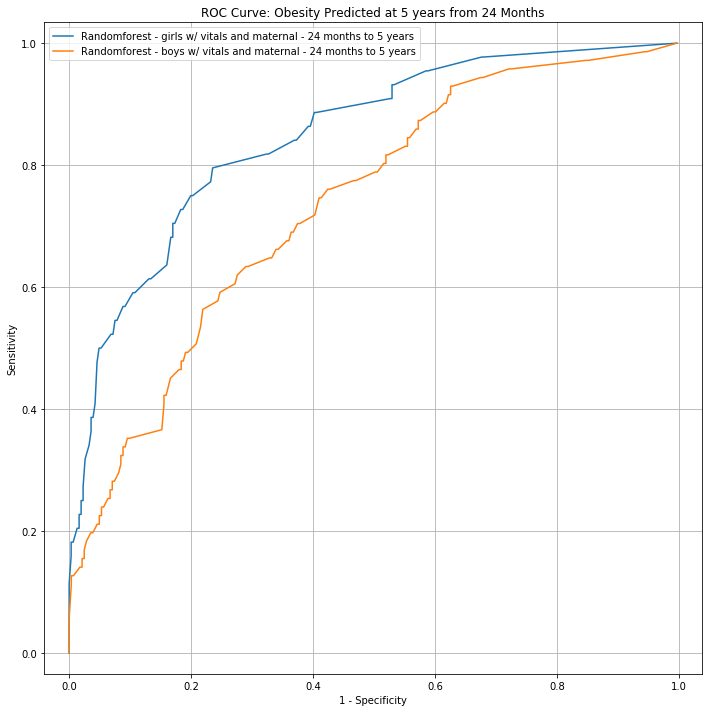

Precision Recall Curve:


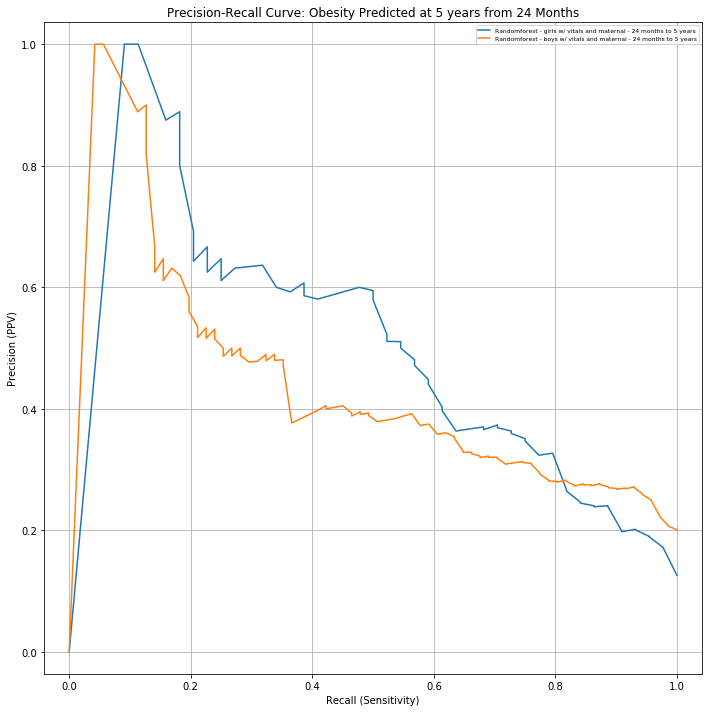

In [9]:
print('ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])
    
plt.legend(fontsize = 10)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid(True);
plt.tight_layout()
plt.savefig('Pediatric_ROC_testing.png', dpi=300)
plt.show()

print('Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    plt.plot(recall_total[ix], prec_total[ix], linestyle='-', label=titles_total[ix])

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 6, loc='upper right')
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid()
plt.tight_layout()
plt.savefig('Pediatric_PR_testing.png', dpi=300)
plt.show()

In [10]:
girls_test_df = pd.DataFrame(np.hstack((xtest_girls, mrnstest_girls.reshape(-1,1), ytest_girls.reshape(-1,1), ytest_pred_girls.reshape(-1,1), ytestlabel_girls.reshape(-1,1))), columns=feature_headers+['mrns','y','y pred', 'y label'])
boys_test_df = pd.DataFrame(np.hstack((xtest_boys, mrnstest_boys.reshape(-1,1), ytest_boys.reshape(-1,1), ytest_pred_boys.reshape(-1,1), ytestlabel_boys.reshape(-1,1))), columns=feature_headers+['mrns','y','y pred', 'y label'])
girls_test_df[['y','y pred']] = girls_test_df[['y','y pred']].astype('float')
boys_test_df[['y','y pred']] = boys_test_df[['y','y pred']].astype('float')
girls_test_df.shape, boys_test_df.shape

((350, 18899), (354, 18899))

In [11]:
fpr_girls, tpr_girls, thresholds_girls = metrics.roc_curve(ytestlabel_girls, ytest_pred_girls)
fpr_boys, tpr_boys, thresholds_boys = metrics.roc_curve(ytestlabel_boys, ytest_pred_boys)

In [42]:
print('@threshold:1.583, sens:0.159, spec:0.997, ppv:0.875, acc:0.891, f1:0.269 total+:8.000')
girls_test_df[girls_test_df['y pred'] > 1.583]

@threshold:1.583, sens:0.159, spec:0.997, ppv:0.875, acc:0.891, f1:0.269 total+:8.000


Diagnosis:9ccsCCS CATEGORY:CCS CATEGORY DESCRIPTION Diagnosis:9ccs0:No DX  \
19                                                 0.0                    0.0   
82                                                 0.0                    0.0   
107                                                0.0                    0.0   
225                                                0.0                    0.0   
243                                                0.0                    0.0   
276                                                0.0                    0.0   
297                                                0.0                    0.0   
306                                                0.0                    0.0   

    Diagnosis:9ccs1:Tuberculosis Diagnosis:9ccs2:Septicemia  \
19                           0.0                        0.0   
82                           0.0                        0.0   
107                          0.0                        0.0   
225                          0.0                        0.0   
243                          0.0                        0.0   
276                          0.0                        0.0   
297                          0.0                        0.0   
306                          0.0                        0.0   

    Diagnosis:9ccs3:Oth bact inf Diagnosis:9ccs4:Mycoses  \
19                           0.0                     0.0   
82                           0.0                     0.0   
107                          0.0                     0.0   
225                          0.0                     0.0   
243                          0.0                     0.0   
276                          0.0                     0.0   
297                          0.0                     0.0   
306                          0.0                     0.0   

    Diagnosis:9ccs5:HIV infectn Diagnosis:9ccs6:Hepatitis  \
19                          0.0                       0.0   
82                          0.0                       0.0   
107                         0.0                       0.0   
225                         0.0                       0.0   
243                         0.0                       0.0   
276                         0.0                       0.0   
297                         0.0                       0.0   
306                         0.0                       0.0   

    Diagnosis:9ccs7:Viral infect Diagnosis:9ccs8:Oth infectns   ...    \
19                           1.0                          0.0   ...     
82                           0.0                          0.0   ...     
107                          0.0                          0.0   ...     
225                          0.0                          0.0   ...     
243                          1.0                          0.0   ...     
276                          1.0                          0.0   ...     
297                          0.0                          0.0   ...     
306                          1.0                          0.0   ...     

    Maternal Procedure History:G0306-otherPregnancy  \
19                                              0.0   
82                                              0.0   
107                                             0.0   
225                                             0.0   
243                                             0.0   
276                                             0.0   
297                                             0.0   
306                                             0.0   

    Maternal Procedure History:G8982-otherPregnancy  \
19                                              0.0   
82                                              0.0   
107                                             0.0   
225                                             0.0   
243                                             0.0   
276                                             0.0   
297                                             0.0   
306                  

In [43]:
print('@threshold:1.113, sens:0.113, spec:0.996, ppv:0.889, acc:0.819, f1:0.200 total+:9.000')
boys_test_df[boys_test_df['y pred'] > 1.113].shape

@threshold:1.113, sens:0.113, spec:0.996, ppv:0.889, acc:0.819, f1:0.200 total+:9.000


(9, 18899)

### Plot the ROC and Precision-Recall Curves

ROC curve:


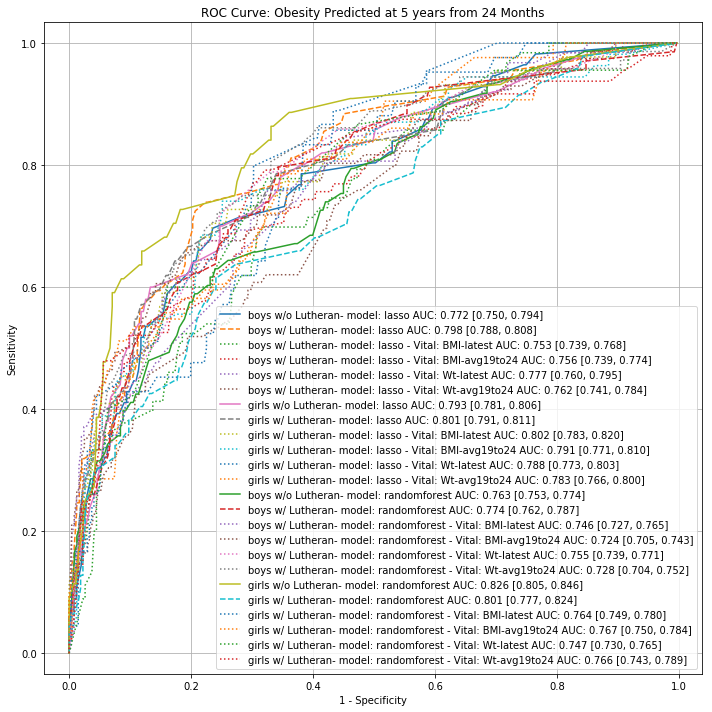

Precision Recall Curve:


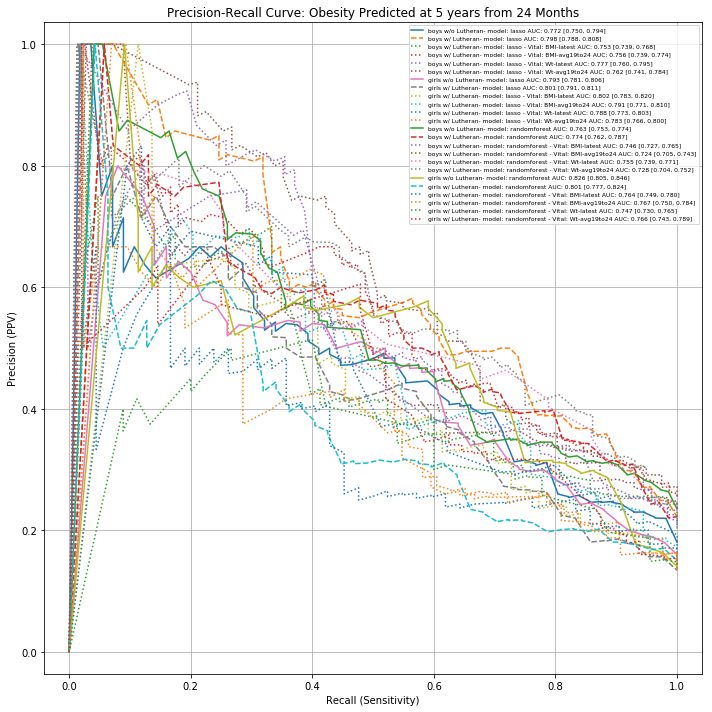

In [20]:
print('ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'Vital' in titles_total[ix]:
        plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle=':', label=titles_total[ix])
    elif 'w/ Lutheran' in titles_total[ix]:
        plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
    else:
        plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])
    
plt.legend(fontsize = 10, )
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid(True);
plt.tight_layout()
plt.savefig('Pediatric_ROC.png', dpi=300)
plt.show()

print('Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'Vital' in titles_total[ix]:
        plt.plot(recall_total[ix], prec_total[ix], linestyle=':', label=titles_total[ix])
    elif 'w/ Lutheran' in titles_total[ix]:
        plt.plot(recall_total[ix], prec_total[ix], linestyle='--', label=titles_total[ix])
    else:
        plt.plot(recall_total[ix], prec_total[ix], linestyle='-', label=titles_total[ix])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 6, loc='upper right')
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid()
plt.tight_layout()
plt.savefig('Pediatric_PR.png', dpi=300)
plt.show()

ROC curve:


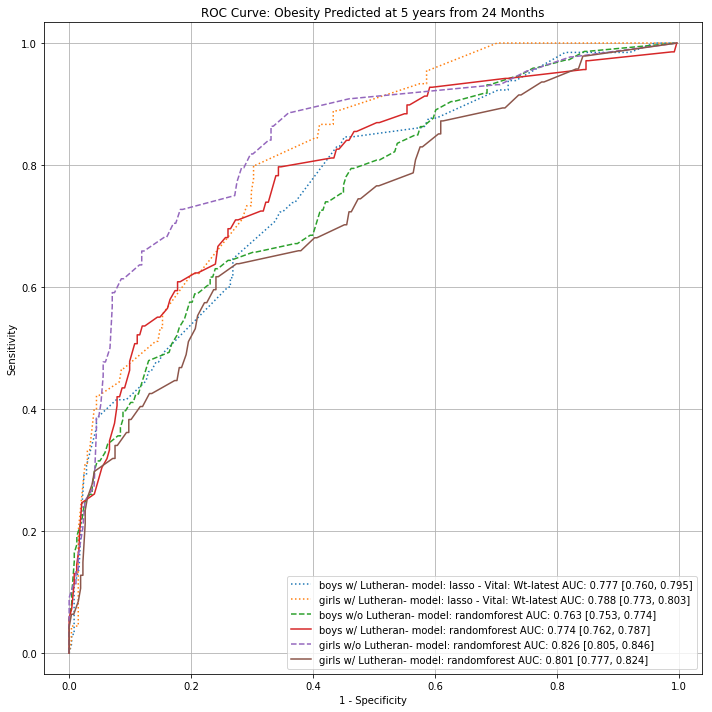

Precision Recall Curve:


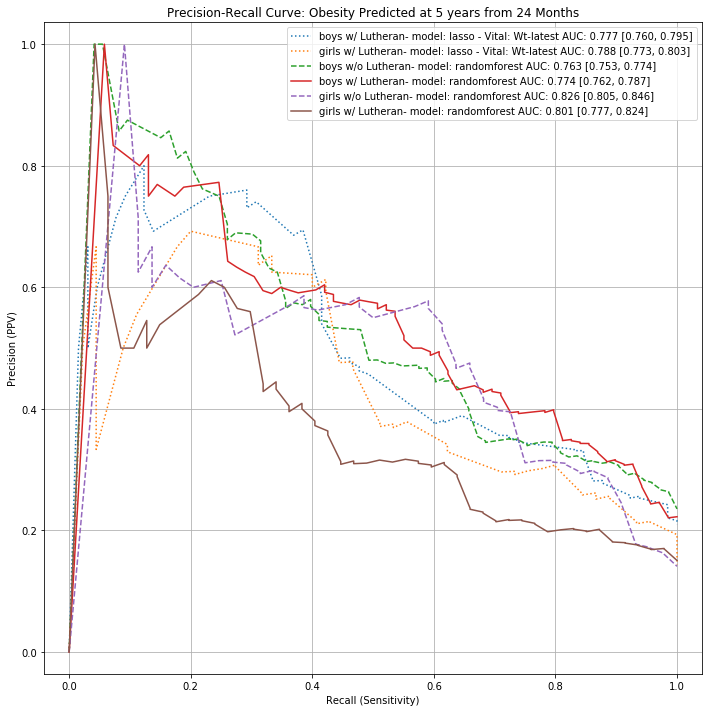

In [19]:
print('ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'w/ Lutheran- model: lasso - Vital: Wt-latest' in titles_total[ix] or 'model: randomforest AUC:' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle=':', label=titles_total[ix])
        else:
            if 'w/ Lutheran' in titles_total[ix]:
                plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])
            else:
                plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
    
plt.legend(fontsize = 10, )
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid(True);
plt.tight_layout()
plt.savefig('Pediatric_ROC_limited.png', dpi=300)
plt.show()

print('Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'w/ Lutheran- model: lasso - Vital: Wt-latest' in titles_total[ix] or 'model: randomforest AUC:' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(recall_total[ix], prec_total[ix], linestyle=':', label=titles_total[ix])
        else:
            if 'w/ Lutheran' in titles_total[ix]:
                plt.plot(recall_total[ix], prec_total[ix], linestyle='-', label=titles_total[ix])
            else: 
                plt.plot(recall_total[ix], prec_total[ix], linestyle='--', label=titles_total[ix])

plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 10)
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity Predicted at 5 years from 24 Months')
plt.grid()
plt.tight_layout()
plt.savefig('Pediatric_PR_limited.png', dpi=300)
plt.show()

In [5]:
titles_total

['boys w/o Lutheran- model: lasso AUC: 0.772 [0.750, 0.794]',
 'boys w/ Lutheran- model: lasso AUC: 0.798 [0.788, 0.808]',
 'boys w/ Lutheran- model: lasso - Vital: BMI-latest AUC: 0.753 [0.739, 0.768]',
 'boys w/ Lutheran- model: lasso - Vital: BMI-avg19to24 AUC: 0.756 [0.739, 0.774]',
 'boys w/ Lutheran- model: lasso - Vital: Wt-latest AUC: 0.777 [0.760, 0.795]',
 'boys w/ Lutheran- model: lasso - Vital: Wt-avg19to24 AUC: 0.762 [0.741, 0.784]',
 'girls w/o Lutheran- model: lasso AUC: 0.793 [0.781, 0.806]',
 'girls w/ Lutheran- model: lasso AUC: 0.801 [0.791, 0.811]',
 'girls w/ Lutheran- model: lasso - Vital: BMI-latest AUC: 0.802 [0.783, 0.820]',
 'girls w/ Lutheran- model: lasso - Vital: BMI-avg19to24 AUC: 0.791 [0.771, 0.810]',
 'girls w/ Lutheran- model: lasso - Vital: Wt-latest AUC: 0.788 [0.773, 0.803]',
 'girls w/ Lutheran- model: lasso - Vital: Wt-avg19to24 AUC: 0.783 [0.766, 0.800]',
 'boys w/o Lutheran- model: randomforest AUC: 0.763 [0.753, 0.774]',
 'boys w/ Lutheran- mod

Girls ROC curve:


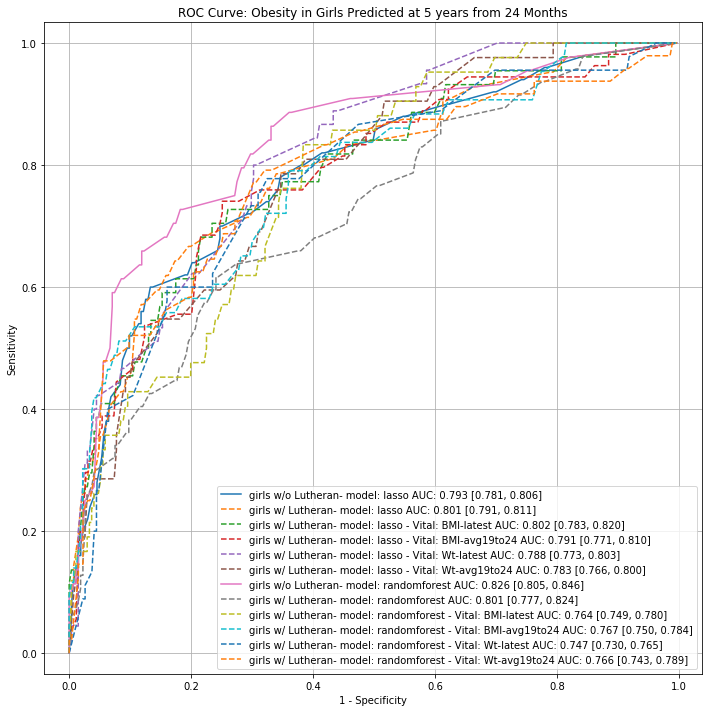

Girls Precision Recall Curve:


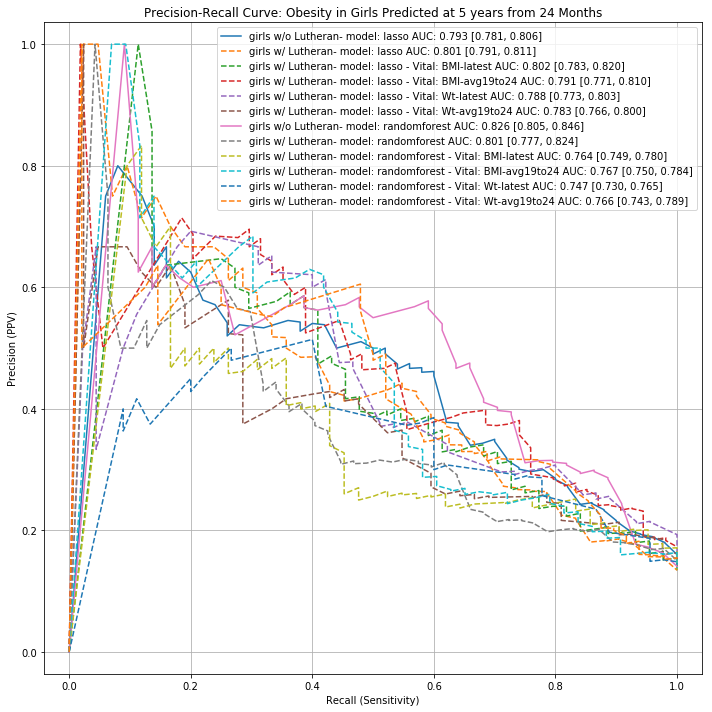

In [23]:
print('Girls ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'girls' in titles_total[ix]:
        if 'w/ Lutheran' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
        else:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])

plt.legend(fontsize = 10)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity in Girls Predicted at 5 years from 24 Months')
plt.grid(True)
plt.tight_layout()
plt.savefig('Pediatric_Girls_ROC.png', dpi=300)
plt.show()

print('Girls Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'girls' in titles_total[ix]:
        if 'w/ Lutheran' in titles_total[ix]:
            plt.plot(recall_total[ix], prec_total[ix], linestyle='--', label=titles_total[ix])
        else:
            plt.plot(recall_total[ix], prec_total[ix], linestyle='-', label=titles_total[ix])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 10)
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity in Girls Predicted at 5 years from 24 Months')
plt.grid()
plt.tight_layout()
plt.savefig('Pediatric_Girls_PR.png', dpi=300)
plt.show()

Girls Zoomed ROC curve:


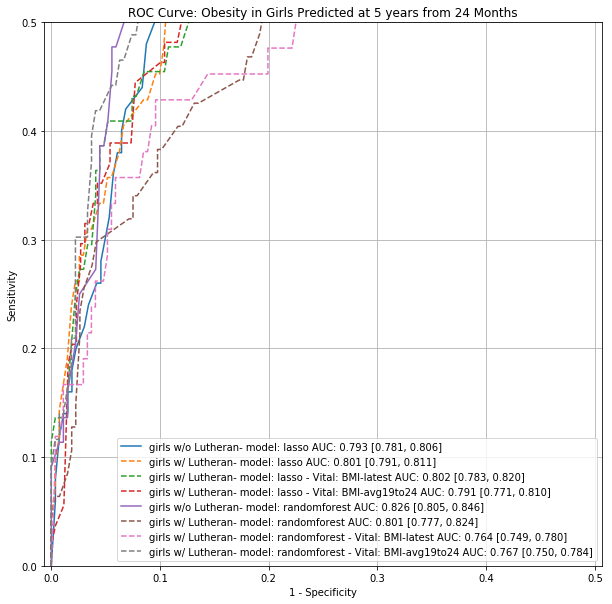

In [7]:
print('Girls Zoomed ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'girls' in titles_total[ix] and 'Vital: Wt-' not in titles_total[ix]:
        if 'w/ Lutheran' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
        else:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])

plt.legend(fontsize = 10, loc='lower right')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity in Girls Predicted at 5 years from 24 Months')
plt.grid(True);
plt.xlim((0,0.5))
plt.ylim((0,0.5))
plt.savefig('Pediatric_Girls_ROC_zoomed.png', dpi=300)
plt.show()

ROC curve:


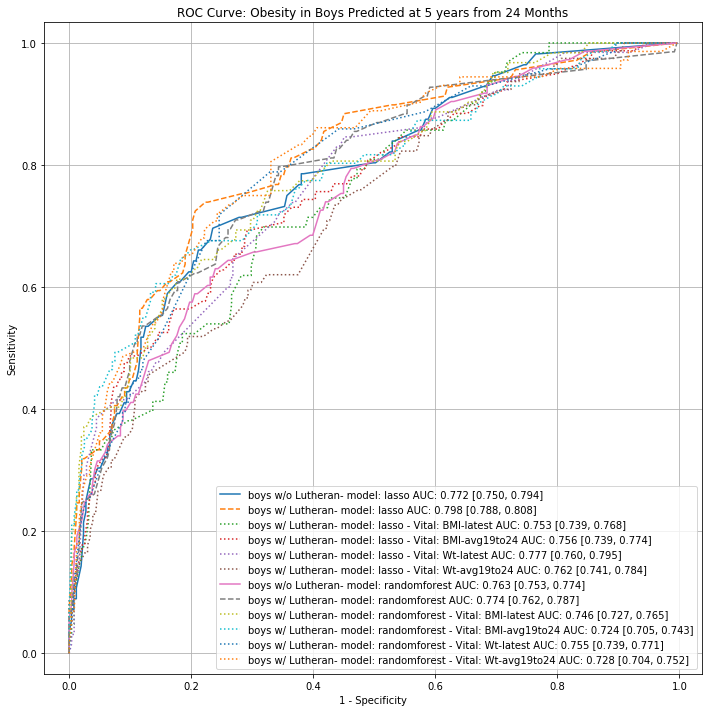

Boys Precision Recall Curve:


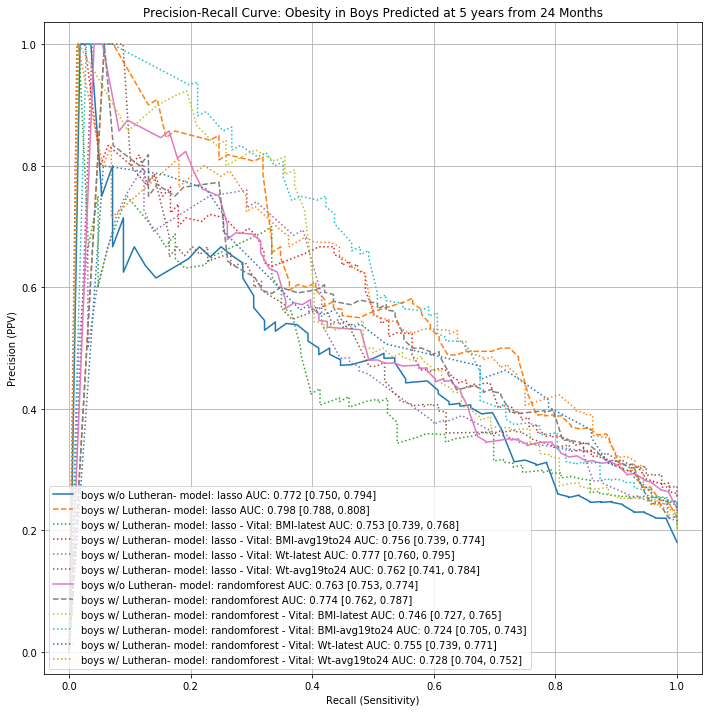

In [25]:
print('ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'boys' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle=':', label=titles_total[ix])
        elif 'w/ Lutheran' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
        else:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])
    
plt.legend(fontsize = 10)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity in Boys Predicted at 5 years from 24 Months')
plt.grid(True)
plt.tight_layout()
plt.savefig('Pediatric_Boys_ROC.png', dpi=300)
plt.show()

print('Boys Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'boys' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(recall_total[ix], prec_total[ix], linestyle=':', label=titles_total[ix])
        elif 'w/ Lutheran' in titles_total[ix]:
            plt.plot(recall_total[ix], prec_total[ix], linestyle='--', label=titles_total[ix])
        else:
            plt.plot(recall_total[ix], prec_total[ix], linestyle='-', label=titles_total[ix])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 10)
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity in Boys Predicted at 5 years from 24 Months')
plt.grid()
plt.tight_layout()
plt.savefig('Pediatric_Boys_PR.png', dpi=300)
plt.show()

Boys Zoomed ROC curve:


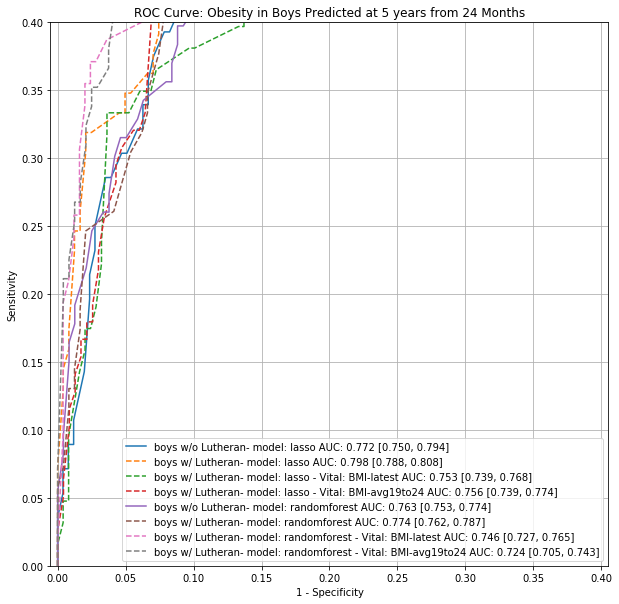

In [9]:
print('Boys Zoomed ROC curve:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_total)):
    if 'boys' in titles_total[ix] and 'Vital: Wt-' not in titles_total[ix]:
        if 'w/ Lutheran' in titles_total[ix]:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='--', label=titles_total[ix])
        else:
            plt.plot(1- np.array(spec_total[ix]), np.array(recall_total[ix]), linestyle='-', label=titles_total[ix])

plt.legend(fontsize = 10, loc='lower right')
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity in Boys Predicted at 5 years from 24 Months')
plt.grid(True);
plt.xlim((0,0.4))
plt.ylim((0,0.4))
plt.savefig('Pediatric_Boys_ROC_zoomed.png', dpi=300)
plt.show()

### Exploring the data

In [17]:
x_mat_df = pd.DataFrame(x_w_maternal, columns=feature_headers)
x_no_mat_df = pd.DataFrame(x_no_maternal, columns=feature_headers)

x_mat_df['mrns'] = mrns.reshape(-1,1)
x_mat_df['y'] = y.reshape(-1,1)
x_mat_df['y label'] = y_label.reshape(-1,1)

x_no_mat_df['mrns'] = mrns.reshape(-1,1)
x_no_mat_df['y'] = y.reshape(-1,1)
x_no_mat_df['y label'] = y_label.reshape(-1,1)

In [ ]:
boys_lutheran_df = pickle.load(open('boys_lutheran_df.pkl', 'rb'))
girls_lutheran_df = pickle.load(open('girls_lutheran_df.pkl', 'rb'))
boys_df = pickle.load(open('boys_df.pkl', 'rb'))
girls_df = pickle.load(open('girls_df.pkl', 'rb'))
mrnboys = pickle.load(open('mrnboys.pkl', 'rb'))
mrngirls = pickle.load(open('mrngirls.pkl', 'rb'))
y_boys = np.loadtxt('y_boys.txt')
y_girls = np.loadtxt('y_girls.txt')
y_label_boys = np.loadtxt('ylabel_boys.txt')
y_label_girls = np.loadtxt('ylabel_girls.txt')

In [64]:
# boys_lutheran_df['mrns'] = mrnboys.reshape(-1,1)
# boys_df['mrns'] = mrnboys.reshape(-1,1)
# girls_lutheran_df['mrns'] = mrngirls.reshape(-1,1)
# girls_df['mrns'] = mrngirls.reshape(-1,1)

boys_lutheran_df['y'] = y_boys.reshape(-1,1)
boys_df['y'] = y_boys.reshape(-1,1)
boys_lutheran_df['y label'] = y_label_boys.reshape(-1,1)
boys_df['y label'] = y_label_boys.reshape(-1,1)

girls_lutheran_df['y'] = y_girls.reshape(-1,1)
girls_df['y'] = y_girls.reshape(-1,1)
girls_lutheran_df['y label'] = y_label_girls.reshape(-1,1)
girls_df['y label'] = y_label_girls.reshape(-1,1)

In [13]:
x_mat_df[[c for c in feature_headers if 'WEIGHT' in c]+['y', 'y label']].describe()

Maternal Lab History: MATERNAL WEIGHT-prePregnancy  \
count                                            52945.0    
mean                                                 0.0    
std                                                  0.0    
min                                                  0.0    
25%                                                  0.0    
50%                                                  0.0    
75%                                                  0.0    
max                                                  0.0    

       Maternal Lab History: WEIGHT-prePregnancy  \
count                                    52945.0   
mean                                         0.0   
std                                          0.0   
min                                          0.0   
25%                                          0.0   
50%                                          0.0   
75%                                          0.0   
max                                          0.0   

       Maternal Lab History: MATERNAL WEIGHT-firstTrimester  \
count                                            52945.0      
mean                                                 0.0      
std                                                  0.0      
min                                                  0.0      
25%                                                  0.0      
50%                                                  0.0      
75%                                                  0.0      
max                                                  0.0      

       Maternal Lab History: WEIGHT-firstTrimester  \
count                                      52945.0   
mean                                           0.0   
std                                            0.0   
min                                            0.0   
25%                                            0.0   
50%                                            0.0   
75%                                            0.0   
max                                            0.0   

       Maternal Lab History: MATERNAL WEIGHT-secondTrimester  \
count                                            52945.0       
mean                                                 0.0       
std                                                  0.0       
min                                                  0.0       
25%                                                  0.0       
50%                                                  0.0       
75%                                                  0.0       
max                                                  0.0       

       Maternal Lab History: WEIGHT-secondTrimester  \
count                                       52945.0   
mean                                            0.0   
std                                             0.0   
min                                             0.0   
25%                                             0.0   
50%                                             0.0   
75%                                             0.0   
max                                             0.0   

       Maternal Lab History: MATERNAL WEIGHT-thirdTrimester  \
count                                            52945.0      
mean                                                 0.0      
std                                                  0.0      
min                                                  0.0      
25%                                                  0.0      
50%                                                  0.0      
75%                                                  0.0      
max                                                  0.0      

       Maternal Lab History: WEIGHT-thirdTrimester  \
count                                      52945.0   
mean                                           0.0   
std                                            0.0   
min                                            0.0   
25%                   

In [22]:
for c in feature_headers:
    if 'WEIGHT' in c:
        if x_mat_df[x_mat_df[c] > 0].shape[0] > 0:
            print(x_mat_df[x_mat_df[c] > 0][[c,'y','y label']].describe())
            print('\n')

       Maternal Lab History: MATERNAL WEIGHT-postPregnancy           y  \
count                                         112.000000    112.000000   
mean                                          138.415179     16.443994   
std                                            32.454257      2.047203   
min                                            80.500000     12.720000   
25%                                           118.625000     14.998750   
50%                                           131.000000     16.107500   
75%                                           153.000000     17.319167   
max                                           270.000000     24.042500   

          y label  
count  112.000000  
mean     0.160714  
std      0.368918  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000  


       Maternal Lab History: WEIGHT-postPregnancy           y     y label
count                                  247.000000  247.000000  247.000000
mea

### How do the output models perform on the full data set?
#### NOTE: models should really be retrained first

In [51]:
print([x for x in feature_headers if str.lower(x).startswith('gender')])

['Gender:0 male', 'Gender:1 female']


In [57]:
print(x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==1].shape)
print(x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==0].shape)
print(x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==1].shape)
print(x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==0].shape)

(5719, 18823)
(47226, 18823)
(5775, 18823)
(47170, 18823)


In [59]:
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==0]
print(x[x[:,feature_headers.index('Gender:0 male')]==0].shape)
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==0]
print(x[x[:,feature_headers.index('Gender:1 female')]==0].shape)

(41451, 18823)
(41451, 18823)


In [60]:
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==1]
print(x[x[:,feature_headers.index('Gender:0 male')]==0].shape)
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==1]
print(x[x[:,feature_headers.index('Gender:1 female')]==0].shape)

(5719, 18823)
(5775, 18823)


In [61]:
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==0]
print(x[x[:,feature_headers.index('Gender:0 male')]==1].shape)
x=x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==0]
print(x[x[:,feature_headers.index('Gender:1 female')]==1].shape)

(5775, 18823)
(5719, 18823)


In [68]:
print(np.where(x_w_maternal[:,feature_headers.index('Gender:1 female')]==1)[0].shape)
print(np.where(x_w_maternal[:,feature_headers.index('Gender:1 female')]==0)[0].shape)

(5719,)
(47226,)


In [ ]:
if 'girls' in titles_total[ix] and 'w/ Lutheran' in titles_total[ix]:
        x = x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:1 female')]==1]
        ix_list = list(np.where(x_w_maternal[:,feature_headers.index('Gender:1 female')]==1))
    elif 'boys' in titles_total[ix] and 'w/ Lutheran' in titles_total[ix]:
        x = x_w_maternal[x_w_maternal[:,feature_headers.index('Gender:0 male')]==1]
        ix_list = list(np.where(x_w_maternal[:,feature_headers.index('Gender:0 male')]==1))
    elif 'girls' in titles_total[ix] and 'w/o Lutheran' in titles_total[ix]:
        x = x_no_maternal[x_no_maternal[:,feature_headers.index('Gender:1 female')]==1]
        ix_list = list(np.where(x_no_maternal[:,feature_headers.index('Gender:1 female')]==1))
    elif 'boys' in titles_total[ix] and 'w/o Lutheran' in titles_total[ix]:
        x = x_no_maternal[x_no_maternal[:,feature_headers.index('Gender:0 male')]==1]
        ix_list = list(np.where(x_no_maternal[:,feature_headers.index('Gender:0 male')]==1))
    else:
        pass

In [3]:
prec_all = []
recall_all = []
spec_all = []
report_all = []
for ix, clf in enumerate(model_list):
    print(titles_total[ix])
    if 'girls' in titles_total[ix] and 'w/ Lutheran' in titles_total[ix]:
        ix_list = list(np.where(x_w_maternal[:,feature_headers.index('Gender:1 female')]==1)[0])
        x = x_w_maternal[ix_list]
        ytest = y[ix_list]
        ytest_label = y_label[ix_list]
    elif 'boys' in titles_total[ix] and 'w/ Lutheran' in titles_total[ix]:
        ix_list = list(np.where(x_w_maternal[:,feature_headers.index('Gender:0 male')]==1)[0])
        x = x_w_maternal[ix_list]
        ytest = y[ix_list]
        ytest_label = y_label[ix_list]
    elif 'girls' in titles_total[ix] and 'w/o Lutheran' in titles_total[ix]:
        ix_list = list(np.where(x_no_maternal[:,feature_headers.index('Gender:1 female')]==1)[0])
        x = x_no_maternal[ix_list]
        ytest = y[ix_list]
        ytest_label = y_label[ix_list]
    elif 'boys' in titles_total[ix] and 'w/o Lutheran' in titles_total[ix]:
        ix_list = list(np.where(x_no_maternal[:,feature_headers.index('Gender:0 male')]==1)[0])
        x = x_no_maternal[ix_list]
        ytest = y[ix_list]
        ytest_label = y_label[ix_list]
    else:
        pass
    print(x.shape, ytest.shape, ytest_label.shape)
    
    if 'Vital: BMI-latest' in titles_total[ix]:
        y_pred = clf.predict(x[:,feature_headers.index('Vital: BMI-latest')].reshape(-1,1))
        fpr, tpr, thresholds = metrics.roc_curve(ytest_label, y_pred)
        auc = metrics.auc(fpr, tpr)
        r2test = clf.score(x[:,feature_headers.index('Vital: BMI-latest')].reshape(-1,1),ytest)
        exp_var = metrics.explained_variance_score(ytest, y_pred)
        rmse = np.sqrt(((y_pred - ytest)**2).mean())
    elif 'Vital: Wt-latest' in titles_total[ix]:
        y_pred = clf.predict(x[:,feature_headers.index('Vital: Wt-latest')].reshape(-1,1))
        fpr, tpr, thresholds = metrics.roc_curve(ytest_label, y_pred)
        auc = metrics.auc(fpr, tpr)
        r2test = clf.score(x[:,feature_headers.index('Vital: Wt-latest')].reshape(-1,1),ytest)
        exp_var = metrics.explained_variance_score(ytest, y_pred)
        rmse = np.sqrt(((y_pred - ytest)**2).mean())
    elif 'Vital: BMI-avg19to24' in titles_total[ix]:
        y_pred = clf.predict(x[:,feature_headers.index('Vital: BMI-avg19to24')].reshape(-1,1))
        fpr, tpr, thresholds = metrics.roc_curve(ytest_label, y_pred)
        auc = metrics.auc(fpr, tpr)
        r2test = clf.score(x[:,feature_headers.index('Vital: BMI-avg19to24')].reshape(-1,1),ytest)
        exp_var = metrics.explained_variance_score(ytest, y_pred)
        rmse = np.sqrt(((y_pred - ytest)**2).mean())
    elif 'Vital: Wt-avg19to24' in titles_total[ix]:
        y_pred = clf.predict(x[:,feature_headers.index('Vital: Wt-avg19to24')].reshape(-1,1))
        fpr, tpr, thresholds = metrics.roc_curve(ytest_label, y_pred)
        auc = metrics.auc(fpr, tpr)
        r2test = clf.score(x[:,feature_headers.index('Vital: Wt-avg19to24')].reshape(-1,1),ytest)
        exp_var = metrics.explained_variance_score(ytest, y_pred)
        rmse = np.sqrt(((y_pred - ytest)**2).mean())
    else:
        y_pred = clf.predict(x)
        fpr, tpr, thresholds = metrics.roc_curve(ytest_label, y_pred)
        auc = metrics.auc(fpr, tpr)
        r2test = clf.score(x,ytest)
        exp_var = metrics.explained_variance_score(ytest, y_pred)
        rmse = np.sqrt(((y_pred - ytest)**2).mean())

    operating_Thresholds = []
    operating_levels = [0, 0.0001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    ix_level = 0
    for ix, thr in enumerate(thresholds):
        if fpr[ix] >= operating_levels[ix_level]:
            operating_Thresholds.append(thr)
            ix_level += 1
            if ix_level == len(operating_levels):
                break

    operating_Thresholds = thresholds
    report_metrics = 'Whole set metrics:\n'
    prec_list = []
    recall_list = []
    spec_list = []
    for t in operating_Thresholds:
        tp = ((ytest_label > 0) & (y_pred.ravel() > t)).sum()*1.0
        tn = ((ytest_label == 0) & (y_pred.ravel() <= t)).sum()*1.0
        fn = ((ytest_label > 0) & (y_pred.ravel() <= t)).sum()*1.0
        fp = ((ytest_label == 0) & (y_pred.ravel() > t)).sum()*1.0

        sens = tp / (tp + fn) if (tp + fn) != 0 else 0.0
        spec = tn / (tn + fp) if (tn + fp) != 0 else 0.0
        ppv = tp / (tp + fp) if (tp + fp) != 0 else 0.0
        acc = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) != 0 else 0.0
        f1 = 2*tp / (2*tp + fp + fn) if (2*tp + fp + fn) != 0 else 0.0

        report_metrics += '@threshold:{0:4.3f}, sens:{1:4.3f}, spec:{2:4.3f}, ppv:{3:4.3f}, acc:{4:4.3f}, f1:{5:4.3f} total+:{6:4.3f}\n'.format(t, sens, spec, ppv, acc, f1, tp+fp)
        prec_list.append(ppv)
        recall_list.append(sens)
        spec_list.append(spec)
    
    prec_all.append(prec_list)
    recall_all.append(recall_list)
    spec_all.append(spec_list)
    report_all.append(report_metrics)
    
    print('R^2 score test:',r2test)
    print('RMSE score test: {0:4.3f}'.format(rmse))
    print('AUC test: {0:4.3f}'.format(auc))
    print('Explained Variance Score Test: {0:4.3f}'.format(exp_var))
    print('------------------------------------------')

boys w/o Lutheran- model: lasso AUC: 0.772 [0.750, 0.794]
(5775, 18823) (5775,) (5775,)
R^2 score test: -28.5199247916
RMSE score test: 13.930
AUC test: 0.520
Explained Variance Score Test: -4.181
------------------------------------------
boys w/ Lutheran- model: lasso AUC: 0.798 [0.788, 0.808]
(5775, 18823) (5775,) (5775,)
R^2 score test: -28.876276199
RMSE score test: 14.014
AUC test: 0.521
Explained Variance Score Test: -3.951
------------------------------------------
boys w/ Lutheran- model: lasso - Vital: BMI-latest AUC: 0.753 [0.739, 0.768]
(5775, 18823) (5775,) (5775,)
R^2 score test: -25.5605000823
RMSE score test: 13.214
AUC test: 0.529
Explained Variance Score Test: -9.162
------------------------------------------
boys w/ Lutheran- model: lasso - Vital: BMI-avg19to24 AUC: 0.756 [0.739, 0.774]
(5775, 18823) (5775,) (5775,)
R^2 score test: -31.1391719155
RMSE score test: 14.535
AUC test: 0.520
Explained Variance Score Test: -3.286
------------------------------------------
b

In [5]:
for ix, title in enumerate(titles_total):
    print(title)
    print(report_all[ix])
    print('\n------------------------------------------\n')

boys w/o Lutheran- model: lasso AUC: 0.772 [0.750, 0.794]
Whole set metrics:
@threshold:41.325, sens:0.000, spec:1.000, ppv:0.000, acc:0.776, f1:0.000 total+:0.000
@threshold:40.325, sens:0.000, spec:1.000, ppv:0.000, acc:0.776, f1:0.000 total+:0.000
@threshold:21.546, sens:0.000, spec:1.000, ppv:0.000, acc:0.775, f1:0.000 total+:1.000
@threshold:17.256, sens:0.001, spec:1.000, ppv:0.333, acc:0.775, f1:0.002 total+:3.000
@threshold:16.563, sens:0.002, spec:1.000, ppv:0.500, acc:0.776, f1:0.003 total+:4.000
@threshold:15.237, sens:0.005, spec:0.999, ppv:0.700, acc:0.776, f1:0.011 total+:10.000
@threshold:15.117, sens:0.006, spec:0.999, ppv:0.727, acc:0.776, f1:0.012 total+:11.000
@threshold:14.793, sens:0.011, spec:0.999, ppv:0.778, acc:0.777, f1:0.021 total+:18.000
@threshold:14.707, sens:0.012, spec:0.999, ppv:0.750, acc:0.777, f1:0.023 total+:20.000
@threshold:14.677, sens:0.012, spec:0.999, ppv:0.727, acc:0.777, f1:0.024 total+:22.000
@threshold:14.673, sens:0.013, spec:0.999, ppv:0

ROC curve for whole data set:


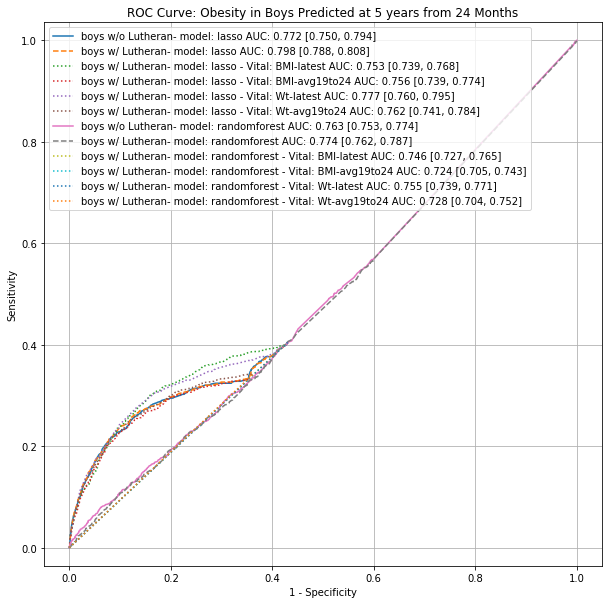

Boys Precision Recall Curve:


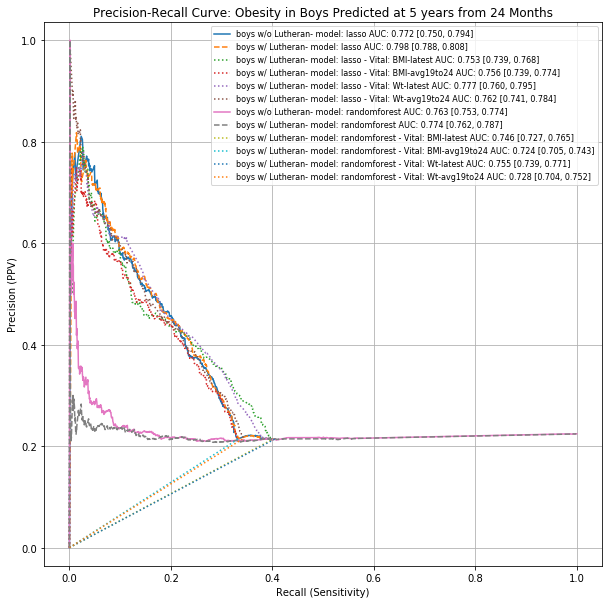

In [4]:
print('ROC curve for whole data set:')

plt.figure(figsize=(10,10))
for ix in range(len(prec_all)):
    if 'boys' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(1- np.array(spec_all[ix]), np.array(recall_all[ix]), linestyle=':', label=titles_total[ix])
        elif 'w/ Lutheran' in titles_total[ix]:
            plt.plot(1- np.array(spec_all[ix]), np.array(recall_all[ix]), linestyle='--', label=titles_total[ix])
        else:
            plt.plot(1- np.array(spec_all[ix]), np.array(recall_all[ix]), linestyle='-', label=titles_total[ix])
    
plt.legend(fontsize = 10)
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.axis('equal')
plt.title('ROC Curve: Obesity in Boys Predicted at 5 years from 24 Months')
plt.grid(True);
plt.savefig('Pediatric_Boys_ROC.png', dpi=300)
plt.show()

print('Boys Precision Recall Curve:')
plt.figure(figsize=(10,10))
for ix in range(len(prec_all)):
    if 'boys' in titles_total[ix]:
        if 'Vital' in titles_total[ix]:
            plt.plot(recall_all[ix], prec_all[ix], linestyle=':', label=titles_total[ix])
        elif 'w/ Lutheran' in titles_total[ix]:
            plt.plot(recall_all[ix], prec_all[ix], linestyle='--', label=titles_total[ix])
        else:
            plt.plot(recall_all[ix], prec_all[ix], linestyle='-', label=titles_total[ix])
plt.xlabel('Recall (Sensitivity)')
plt.ylabel('Precision (PPV)')
plt.legend(fontsize = 8)
plt.axis('equal')
plt.title('Precision-Recall Curve: Obesity in Boys Predicted at 5 years from 24 Months')
plt.grid()
plt.savefig('Pediatric_Boys_PR.png', dpi=300)
plt.show()

### Exploring features across models

In [36]:
titles = [t for t in titles_total if 'Vital' not in t]
features = np.zeros((model_list[0].coef_.shape[0], len(titles)))
ix=0
for model in model_list:
    try:
        if model.coef_.shape[0] > 1:
            weights = model.coef_
            features[:,ix] = np.array(weights.ravel())
            ix += 1
    except:
        if model.feature_importances_.shape[0] > 1:
            weights = model.feature_importances_
            features[:,ix] = np.array(weights.ravel())
            ix += 1
    
    
df = pd.DataFrame(features, columns=[t for t in titles_total if 'Vital' not in t])
df.insert(loc=0, column='features', value=feature_headers)
df['mean'] = df.mean(axis=1)
df['std'] = df.std(axis=1)
df['median'] = df.median(axis=1)
df.sort_values(by='mean', ascending=False).head(20)

features  \
4296                    Vital: BMI-avg19to24   
4106                        Vital: Wt-latest   
4098                       Vital: BMI-latest   
4310  Vital: Wt for Len Percentile-avg19to24   
4304                     Vital: Wt-avg19to24   
4252                    Vital: BMI-avg13to16   
4274                    Vital: BMI-avg16to19   
4266  Vital: Wt for Len Percentile-avg13to16   
4282                     Vital: Wt-avg16to19   
4112     Vital: Wt for Len Percentile-latest   
4208                     Vital: BMI-avg7to10   
4230                    Vital: BMI-avg10to13   
4244  Vital: Wt for Len Percentile-avg10to13   
4108             Vital: Wt Percentile-latest   
4142                      Vital: BMI-avg1to3   
4164                      Vital: BMI-avg3to5   
4307                   Vital: Temp-avg19to24   
4194                       Vital: Wt-avg5to7   
4186                      Vital: BMI-avg5to7   
4169                       Vital: Ht-avg3to5   

      boys w/o Lutheran- model: lasso AUC: 0.772 [0.750, 0.794]  \
4296                                           0.299026           
4106                                           0.197439           
4098                                           0.000000           
4310                                           0.000000           
4304                                           0.000000           
4252                                           0.000000           
4274                                           0.000000           
4266                                           0.000000           
4282                                           0.000000           
4112                                           0.000000           
4208                                           0.000000           
4230                                           0.024414           
4244                                           0.000000           
4108                                           0.000000           
4142                                           0.000000           
4164                                           0.000000           
4307                                           0.000000           
4194                                           0.000000           
4186                                           0.000000           
4169                                           0.000000           

      boys w/ Lutheran- model: lasso AUC: 0.798 [0.788, 0.808]  \
4296                                           0.244211          
4106                                           0.191840          
4098                                           0.000000          
4310                                           0.000000          
4304                                           0.036861          
4252                                           0.000000          
4274                                           0.000000          
4266                                           0.000000          
4282                                           0.000000          
4112                                           0.000115          
4208                                           0.000000          
4230                                           0.000000          
4244                                           0.000000          
4108                                           0.002973          
4142                                           0.000000          
4164                                           0.000000          
4307                                           0.000000          
4194                                           0.000000          
4186                                           0.000000          
4169                                          -0.000000          

      girls w/o Lutheran- model: lasso AUC: 0.793 [0.781, 0.806]  \
4296                                           0.364382            
4106                                           0.019035            
4098                        

In [55]:
# df.to_csv('feaure_importances.csv', sep=',', index=False)


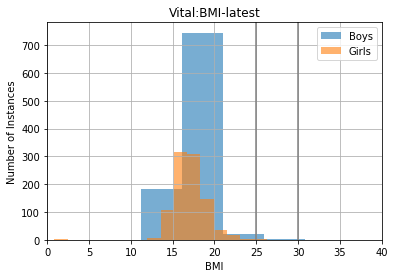

In [40]:
plt.hist(boys_lutheran_df['Vital: BMI-latest'], 20, alpha=0.6, label='Boys')
plt.hist(girls_lutheran_df['Vital: BMI-latest'], 20, alpha=0.6, label='Girls')
plt.axvline(x=25, color='gray')
plt.axvline(x=30, color='gray')
plt.xlim((0,40))
plt.xlabel('BMI')
plt.ylabel('Number of Instances')
plt.title('Vital:BMI-latest')
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('Vital:BMI-latest.png', dpi=300)
plt.show()

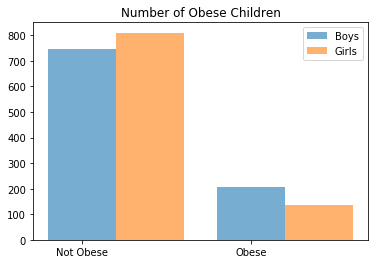

In [41]:
plt.bar(['Not Obese','Obese'], boys_lutheran_df.groupby('y_label').count()['y'].tolist(), width=0.4, alpha=0.6, label='Boys')
plt.bar([0.4,1.4], girls_lutheran_df.groupby('y_label').count()['y'].tolist(), width=0.4, alpha=0.6, label='Girls')
plt.legend(loc='upper right')
plt.title('Number of Obese Children')
plt.savefig('Obesity_Breakdown.png', dpi=300)
plt.show()

In [42]:
boys_df.shape, boys_lutheran_df.shape, girls_df.shape, girls_lutheran_df.shape

((954, 18825), (954, 18825), (945, 18825), (945, 18825))

In [43]:
boys_lutheran_df.groupby('y_label').count()['y']/boys_lutheran_df.y_label.count()

y_label
0.0    0.781971
1.0    0.218029
Name: y, dtype: float64

In [44]:
boys_df.groupby('y_label').count()['y']/boys_df.y_label.count()

y_label
0.0    0.781971
1.0    0.218029
Name: y, dtype: float64

In [45]:
boys_lutheran_df.y_label.count(), girls_lutheran_df.y_label.count()

(954, 945)

In [46]:
girls_lutheran_df.groupby('y_label').count()['y']/girls_lutheran_df.y_label.count()

y_label
0.0    0.857143
1.0    0.142857
Name: y, dtype: float64

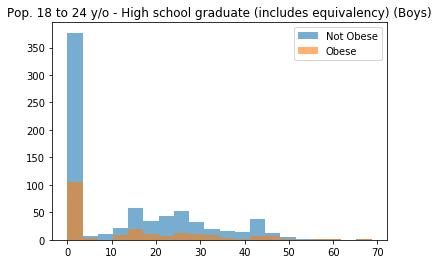

In [47]:
plt.hist(boys_lutheran_df[boys_lutheran_df.y_label==0]["Census:Percent; Estimate; Population 18 to 24 years - High school graduate (includes equivalency)"].values, bins=20, label='Not Obese', alpha=0.6)
plt.hist(boys_lutheran_df[boys_lutheran_df.y_label==1]["Census:Percent; Estimate; Population 18 to 24 years - High school graduate (includes equivalency)"].values, bins=20, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Pop. 18 to 24 y/o - High school graduate (includes equivalency) (Boys)")
plt.savefig('Census_HS_Boys.png', dpi=300)
plt.show()

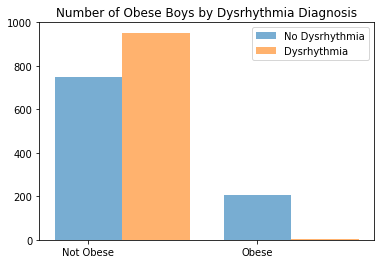

In [48]:
plt.bar(['Not Obese','Obese'], [boys_lutheran_df[(boys_lutheran_df["Diagnosis:9ccs106:Dysrhythmia"]==0) & boys_lutheran_df['y_label']==0]['y'].count(), boys_lutheran_df[(boys_lutheran_df["Diagnosis:9ccs106:Dysrhythmia"]==0) & boys_lutheran_df['y_label']==1]['y'].count()], width=0.4, alpha=0.6, label='No Dysrhythmia')
plt.bar([0.4,1.4], [boys_lutheran_df[(boys_lutheran_df["Diagnosis:9ccs106:Dysrhythmia"]==1) & boys_lutheran_df['y_label']==0]['y'].count(), boys_lutheran_df[(boys_lutheran_df["Diagnosis:9ccs106:Dysrhythmia"]==1) & boys_lutheran_df['y_label']==1]['y'].count()], width=0.4, alpha=0.6, label='Dysrhythmia')

plt.legend(loc='upper right')
plt.title('Number of Obese Boys by Dysrhythmia Diagnosis')
plt.savefig('Obesity_Breakdown_Dysrhythmia.png', dpi=300)
plt.show()

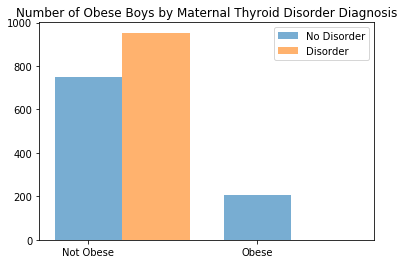

In [49]:
plt.bar(['Not Obese','Obese'], [boys_lutheran_df[(boys_lutheran_df["Maternal Diagnosis:9ccs48:Thyroid dsor"]==0) & boys_lutheran_df['y_label']==0]['y'].count(), boys_lutheran_df[(boys_lutheran_df["Maternal Diagnosis:9ccs48:Thyroid dsor"]==0) & boys_lutheran_df['y_label']==1]['y'].count()], width=0.4, alpha=0.6, label='No Disorder')
plt.bar([0.4,1.4], [boys_lutheran_df[(boys_lutheran_df["Maternal Diagnosis:9ccs48:Thyroid dsor"]==1) & boys_lutheran_df['y_label']==0]['y'].count(), boys_lutheran_df[(boys_lutheran_df["Maternal Diagnosis:9ccs48:Thyroid dsor"]==1) & boys_lutheran_df['y_label']==1]['y'].count()], width=0.4, alpha=0.6, label='Disorder')

plt.legend(loc='upper right')
plt.title('Number of Obese Boys by Maternal Thyroid Disorder Diagnosis')
plt.savefig('Obesity_Breakdown_Mat_Thyroid_Disorder.png', dpi=300)
plt.show()

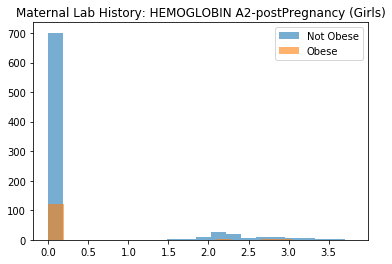

In [115]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Maternal Lab History: HEMOGLOBIN A2-postPregnancy"].values, bins=20, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Maternal Lab History: HEMOGLOBIN A2-postPregnancy"].values, bins=20, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Maternal Lab History: HEMOGLOBIN A2-postPregnancy (Girls)")
plt.savefig('Mat_HEMO_A2_Post_Girls.png', dpi=300)
plt.show()

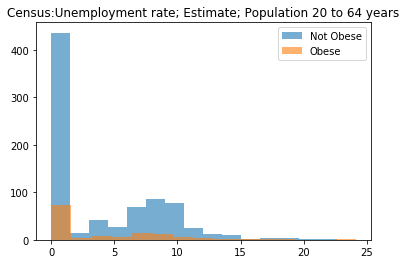

In [105]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Census:Unemployment rate; Estimate; Population 20 to 64 years"].values, bins=15, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Census:Unemployment rate; Estimate; Population 20 to 64 years"].values, bins=15, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Census:Unemployment rate; Estimate; Population 20 to 64 years")
# plt.savefig('Mat_HEMO_A2_Post.png', dpi=300)
plt.show()

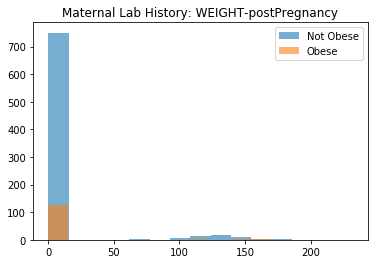

In [106]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Maternal Lab History: WEIGHT-postPregnancy"].values, bins=15, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Maternal Lab History: WEIGHT-postPregnancy"].values, bins=15, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Maternal Lab History: WEIGHT-postPregnancy")
# plt.savefig('Mat_HEMO_A2_Post.png', dpi=300)
plt.show()

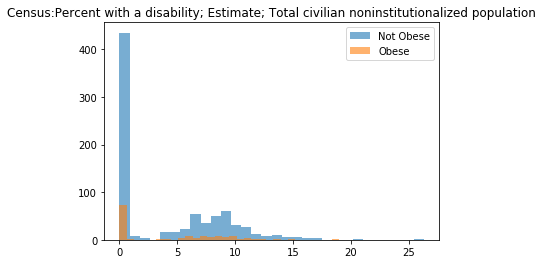

In [110]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Census:Percent with a disability; Estimate; Total civilian noninstitutionalized population"].values, bins=30, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Census:Percent with a disability; Estimate; Total civilian noninstitutionalized population"].values, bins=30, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Census:Percent with a disability; Estimate; Total civilian noninstitutionalized population")
# plt.savefig('Mat_HEMO_A2_Post.png', dpi=300)
plt.show()

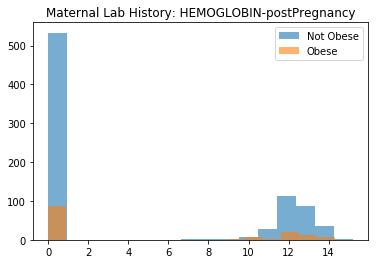

In [112]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Maternal Lab History: HEMOGLOBIN-postPregnancy"].values, bins=16, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Maternal Lab History: HEMOGLOBIN-postPregnancy"].values, bins=16, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Maternal Lab History: HEMOGLOBIN-postPregnancy")
# plt.savefig('Mat_HEMO_A2_Post.png', dpi=300)
plt.show()

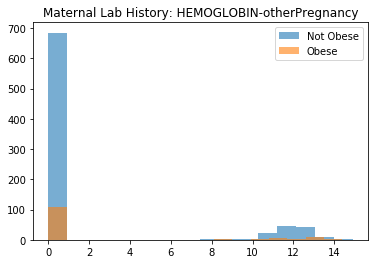

In [113]:
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==0]["Maternal Lab History: HEMOGLOBIN-otherPregnancy"].values, bins=16, label='Not Obese', alpha=0.6)
plt.hist(girls_lutheran_df[girls_lutheran_df.y_label==1]["Maternal Lab History: HEMOGLOBIN-otherPregnancy"].values, bins=16, label='Obese', alpha=0.6)
plt.legend(loc='upper right')
plt.title("Maternal Lab History: HEMOGLOBIN-otherPregnancy")
# plt.savefig('Mat_HEMO_A2_Post.png', dpi=300)
plt.show()